# Active Learning Demo for Materiom 

Installing required packages

In [82]:
!pip install GPy
!pip install emukit

Importing required libraries

In [83]:
import math #supporting library for math
import numpy as np #library handling arrays and matrices
import matplotlib.pyplot as plt #plotting tools
import warnings
warnings.filterwarnings('ignore')

import GPy #Gaussian Proccesses library
import emukit #Active learning and Bayesian Optimization library

from numpy.random import seed
seed(12345) #setting a specific numpy seed at the begining of our code 
#ensures reproducability of our code results, as every psuedorandom variable 
#is initialised with the same value no matter how many times we run the code

### One step back: Gaussian Proccesses
Gaussian Processes define a probability distribution across classes of functions (usually smooth). GPs are fully parametrized by a mean $\mu(x)$ and a covariance matrix $K(x,x’)$.
Gaussian Process: $P(X) ~ N($\mu$,K)$
* $\mu(x^*)=K_{*x}(K_{xx}+\sigma^2I)^{-1}y$
* $\sigma^2(x^*)=K_{**}-K_{*x}(K_{xx}+\sigma^2I)^{-1}K_{*x}^T$

The kernel $K$ represents some prior knowledge regarding the phenomenon or data that we wanna analyze.

Let's see how using different kernels impacts the possible curves.

The following plots demonstrate samples from a Gaussian process prior and the corresponding covariance matrix


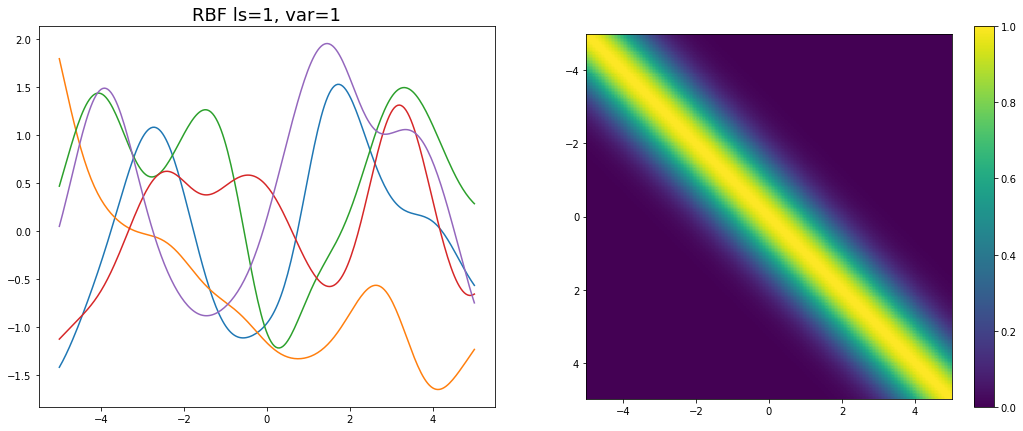

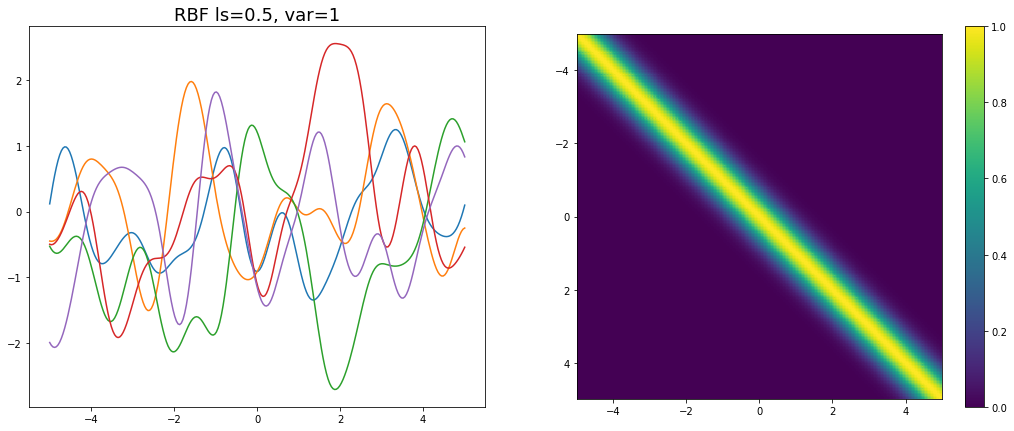

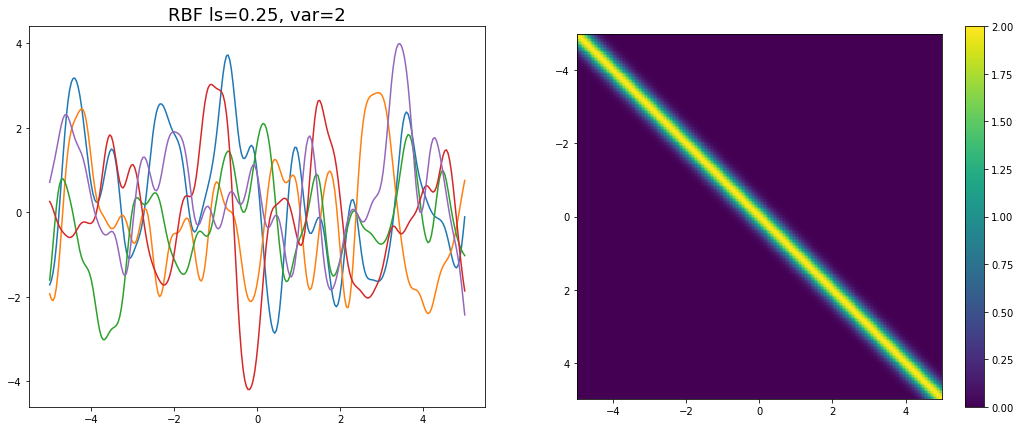

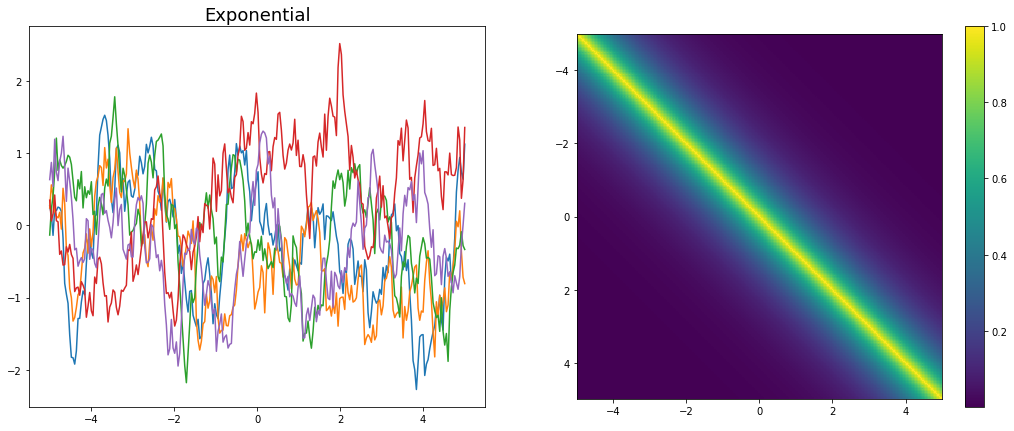

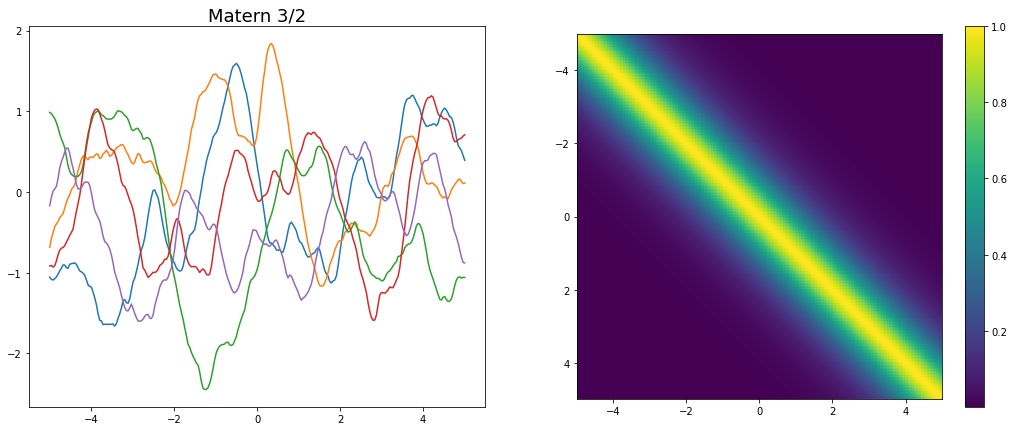

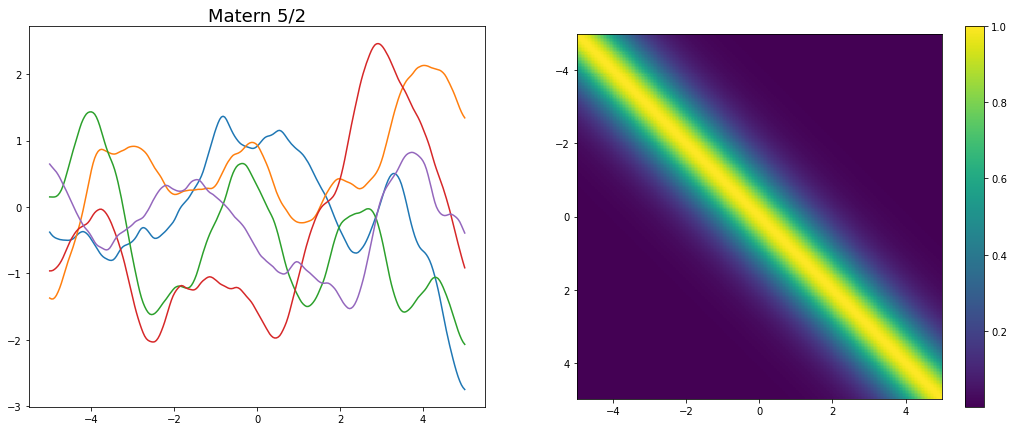

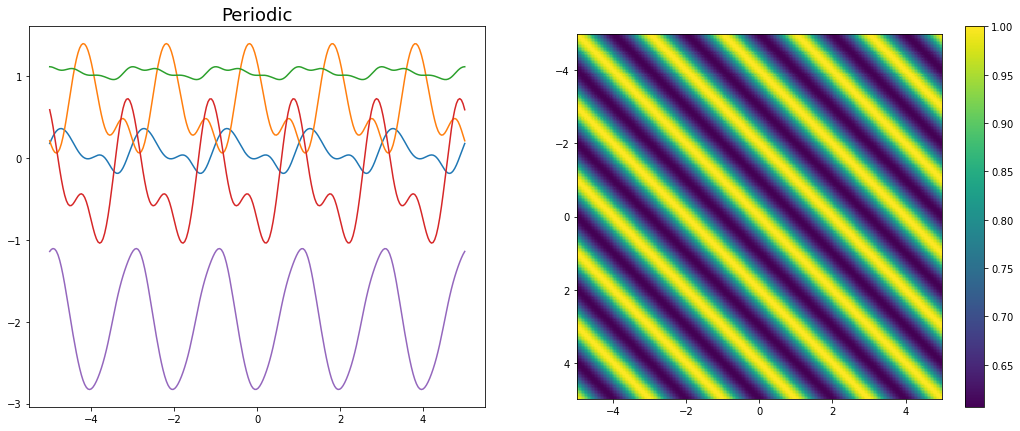

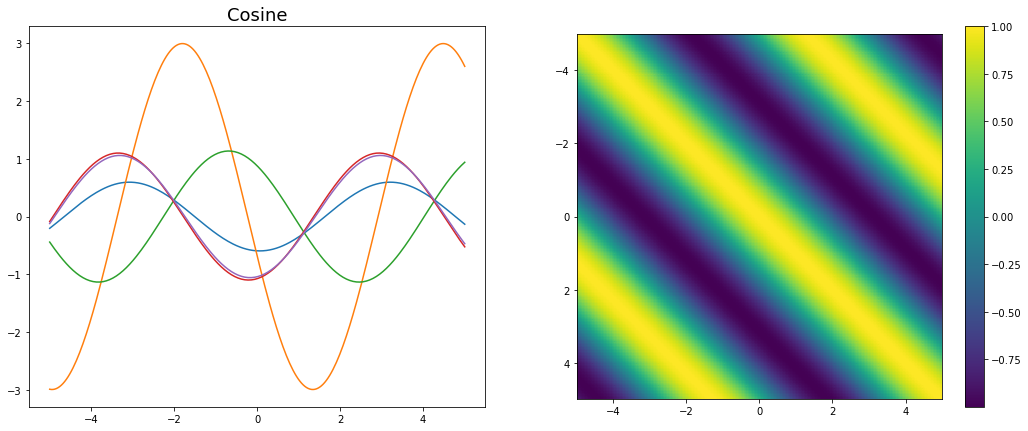

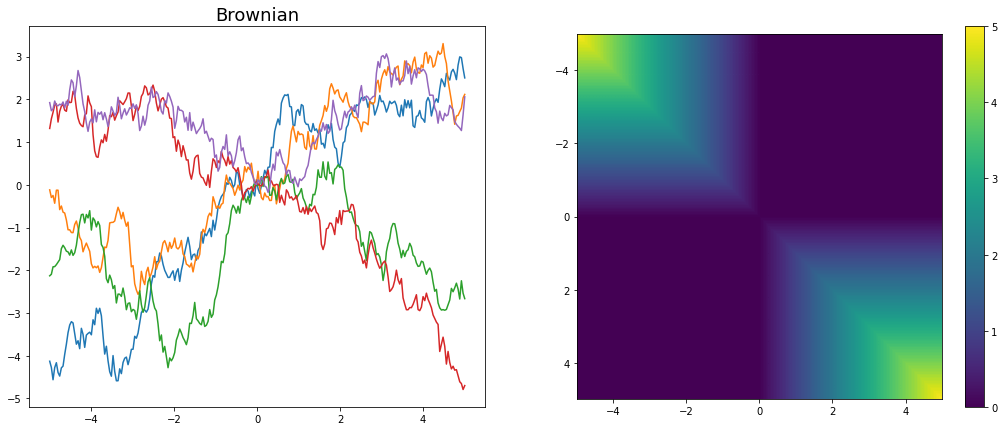

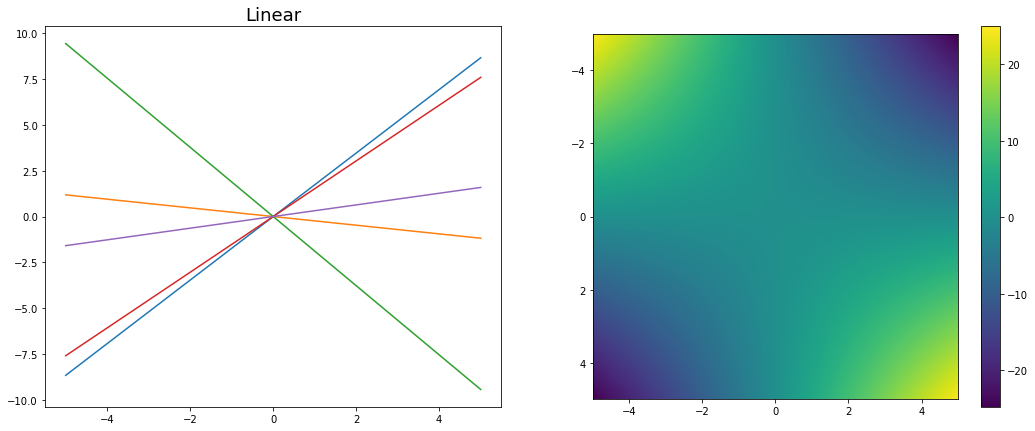

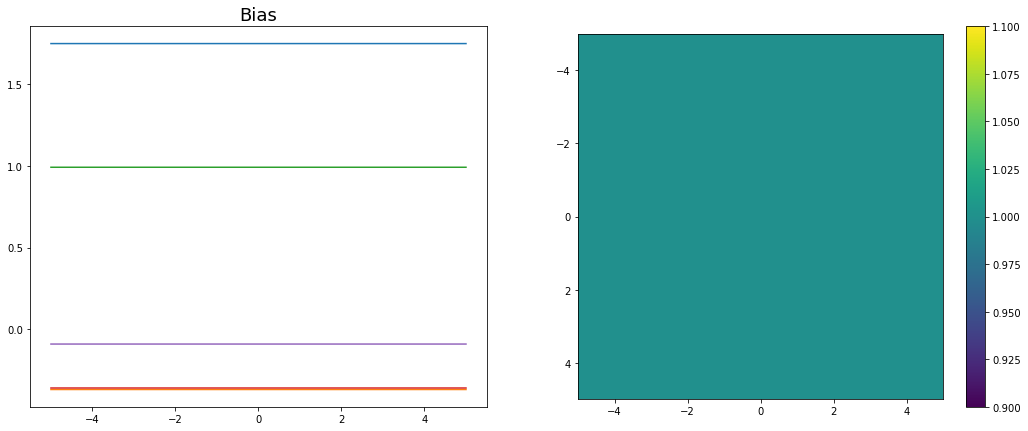

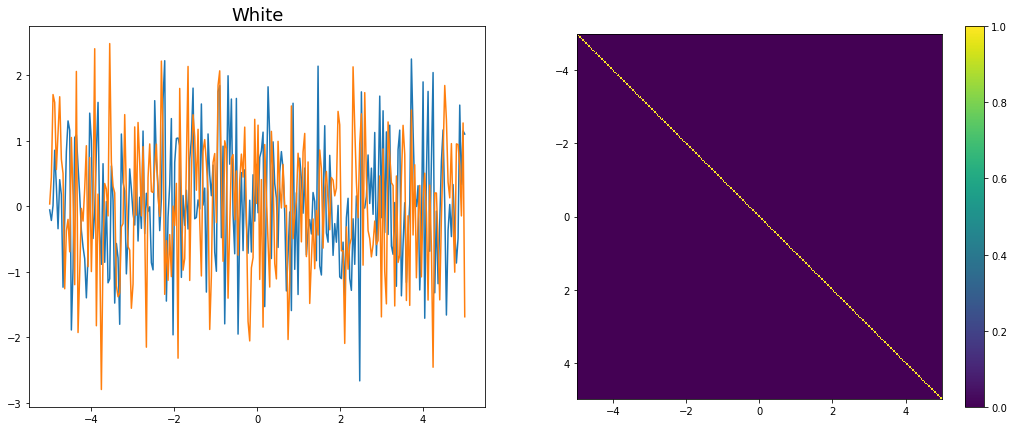

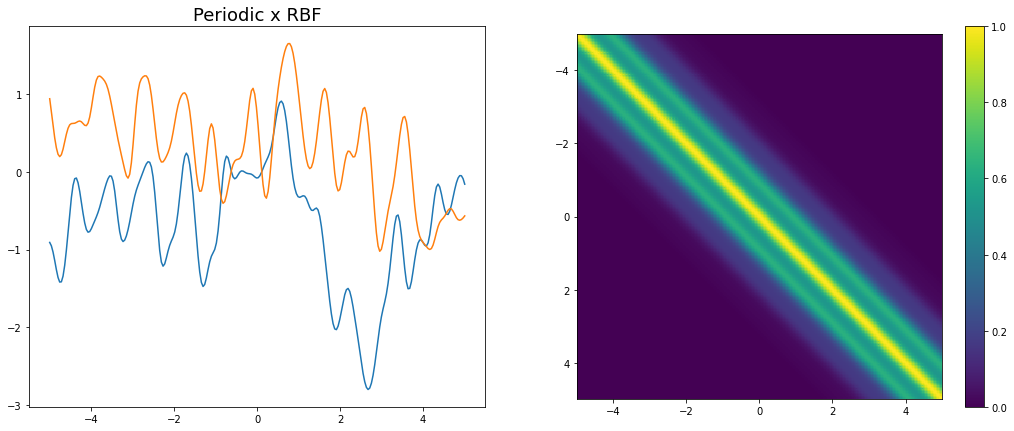

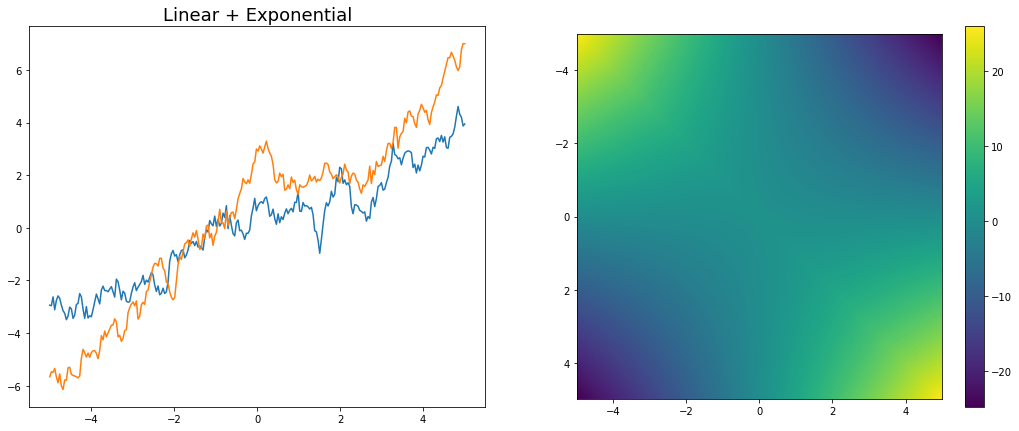

In [84]:
# Exploring how the use of different kernels can dramatically affect our results
ks = [ # List of example kernels
    GPy.kern.RBF(1, lengthscale=1.), # the most commonly used kernel
    GPy.kern.RBF(1, lengthscale=0.5),
    GPy.kern.RBF(1, lengthscale=0.25, variance=2.), #first three cases, just playing with the lengthscale and the variance
    GPy.kern.Exponential(1),
    GPy.kern.Matern32(1),
    GPy.kern.Matern52(1),
    GPy.kern.StdPeriodic(1, period=2.),
    GPy.kern.Cosine(1),
    GPy.kern.Brownian(1),
    GPy.kern.Linear(1),
    GPy.kern.Bias(1),
    GPy.kern.White(1),
    GPy.kern.StdPeriodic(1)*GPy.kern.RBF(1),
    GPy.kern.Linear(1) + GPy.kern.Exponential(1)
]
# The name of our kernels (for the legend)
kernel_name = ["RBF ls=1, var=1", "RBF ls=0.5, var=1", "RBF ls=0.25, var=2", "Exponential", "Matern 3/2", 
               "Matern 5/2", "Periodic", "Cosine", "Brownian", "Linear", "Bias", "White", "Periodic x RBF", "Linear + Exponential"]

# Our sample space
X = np.linspace(-5., 5., 250)[:, None]

print("The following plots demonstrate samples from a Gaussian process prior and the corresponding covariance matrix")

# Loop through our kernels
for i,k in enumerate(ks):
    # The mean function is set to 0
    mu = np.zeros((250)) # we have 250 sample inputs
    # Get the covariance matrix
    if i is not 11:
        C  = k.K(X,X)
    else: # We have to sample White noise kernel differently
        C = k.K(X)
        
    # Sample 5 times from a multivariate Gaussian distribution with mean 0 and covariance k(X,X)
    Z  = np.random.multivariate_normal(mu, C, 5)
    
    # Setup figure environment
    plt.figure(figsize=(18, 7))
    
    # Show samples on left hand side
    plt.subplot(121)
    for j in range(5 if i < 11 else 2): # Loop through samples
        plt.plot(X[:],Z[j,:])
        plt.title(kernel_name[i], fontsize=18)
        
    # Visualise covariance matrix on right hand side
    plt.subplot(122)
    plt.pcolor(X.T, X, C)
    # Annotate plot
    plt.gca().invert_yaxis(), plt.gca().axis("image")
    plt.colorbar()

Defining a function that will allow us to visualize our results from now on

In [96]:
def plot_gp(X, m, C, training_points=None):
    """ Plotting utility to plot a GP fit with 95% confidence interval """
    # Plot 95% confidence interval 
    plt.fill_between(X[:,0],
                     m[:,0] - 1.96*np.sqrt(var[:,0]),
                     m[:,0] + 1.96*np.sqrt(var[:,0]),
                     alpha=0.5)
    # Plot GP mean and initial training points
    plt.plot(X, m, "-")
    
    plt.xlabel("x")
    plt.ylabel("f(x)")
    
    # Plot training points if included
    if training_points is not None:
        X_, Y_ = training_points
        plt.plot(X_, Y_, "kx", mew=2)

Let's mow explore how picking the right kernel can lead to better GP regression fit.
We will explore two cases. In case one a function will be generated
$$f(x) = sin(2x)+0.2x$$ and some errer will be introduced while sampling points $$y = f(x)+\epsilon$$, 
in case two the forrester function will be used


#### Case 1

Text(0, 0.5, 'f(x)')

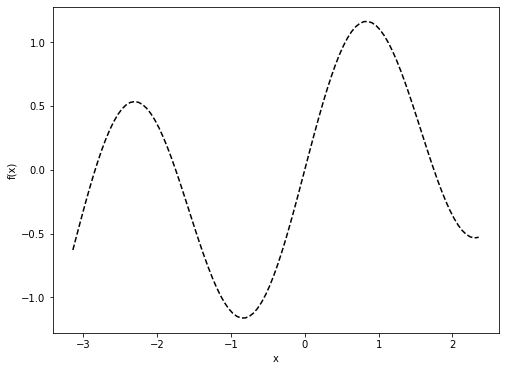

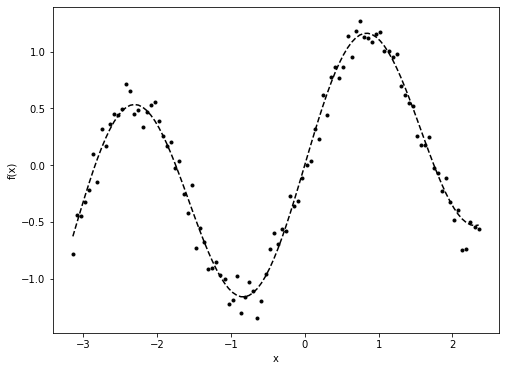

In [97]:
## the function we're going to use
f = lambda xi: np.sin(xi * 2) + .2*xi

# sampling space
N = 100 # picking 100 points
X_grid = np.linspace(-np.pi, np.pi*3/4, N)[:,None]
Y_grid = f(X_grid)
Y_grid.shape

# Show function
FIGSIZE = (8, 6)
plt.figure(figsize=FIGSIZE)
plt.plot(X_grid, Y_grid,'k--')
plt.xlabel('x')
plt.ylabel('f(x)')
# Show function with noise
plt.figure(figsize=FIGSIZE)
plt.plot(X_grid, Y_grid,'k--')
plt.plot(X_grid, Y_grid + np.random.normal(0., .1, X_grid.shape) ,'k.')
plt.xlabel('x')
plt.ylabel('f(x)')

In [98]:
#sampling 5 data points to perform regression at
# we sample the function and look at GP prediction
# Sample from the function
# Number of samples 
num_measurements = 5

# Random sample locations
X_samples = np.random.uniform(-np.pi, np.pi * 3/4, (num_measurements, 1))

# Get the function value with noise
Y_samples = f(X_samples) + np.random.normal(0., .1, (X_samples.shape[0],1))

- Using RBF kernel

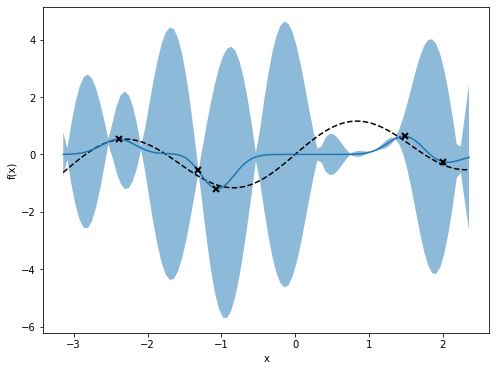

In [99]:
# Set up the kernel and the GP model
k = GPy.kern.RBF(1)
m = GPy.models.GPRegression(X_samples, Y_samples, k)

# optimize hyperparameters
m.optimize('bfgs', max_iters=100)
    
# Identify the mean and covariance of the GP fit over the grid
mean, Cov = m.predict(X_grid, full_cov=True)

# Plot the generating curve and the GP
plt.figure(figsize = (8,6))
plt.plot(X_grid, Y_grid,'k--')
plot_gp(X_grid, mean, Cov, training_points=(X_samples,Y_samples))
m

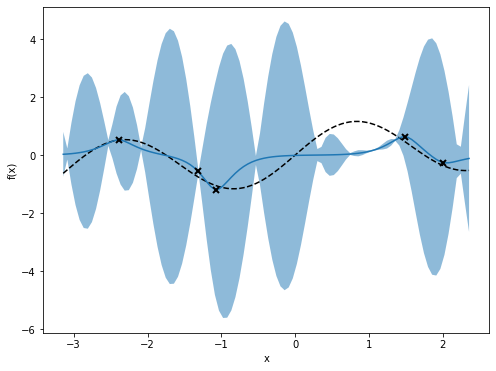

In [100]:
# Set up the kernel and the GP model
k = GPy.kern.Matern32(1)
m = GPy.models.GPRegression(X_samples, Y_samples, k)

# optimize hyperparameters
m.optimize('bfgs', max_iters=100)
    
# Identify the mean and covariance of the GP fit over the grid
mean, Cov = m.predict(X_grid, full_cov=True)

# Plot the generating curve and the GP
plt.figure(figsize = (8,6))
plt.plot(X_grid, Y_grid,'k--')
plot_gp(X_grid, mean, Cov, training_points=(X_samples,Y_samples))
m

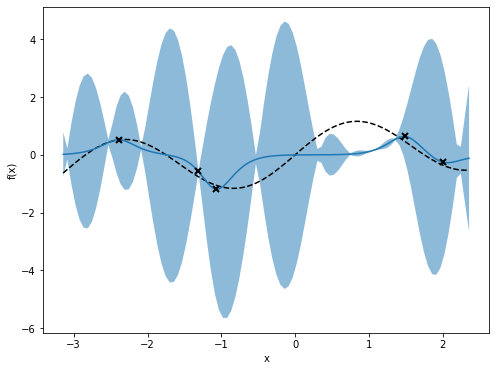

In [101]:
# Set up the kernel and the GP model
k = GPy.kern.Matern52(1)
m = GPy.models.GPRegression(X_samples, Y_samples, k)

# optimize hyperparameters
m.optimize('bfgs', max_iters=100)
    
# Identify the mean and covariance of the GP fit over the grid
mean, Cov = m.predict(X_grid, full_cov=True)

# Plot the generating curve and the GP
plt.figure(figsize = (8,6))
plt.plot(X_grid, Y_grid,'k--')
plot_gp(X_grid, mean, Cov, training_points=(X_samples,Y_samples))
m

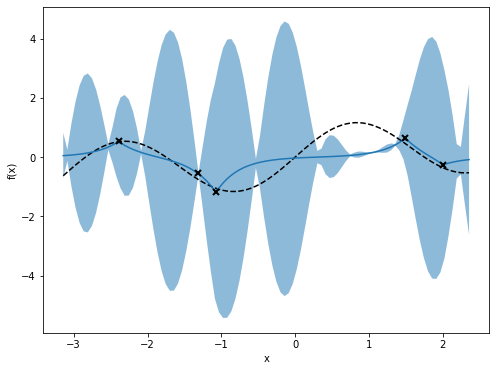

In [102]:
# Set up the kernel and the GP model
k = GPy.kern.Exponential(1)
m = GPy.models.GPRegression(X_samples, Y_samples, k)

# optimize hyperparameters
m.optimize('bfgs', max_iters=100)
    
# Identify the mean and covariance of the GP fit over the grid
mean, Cov = m.predict(X_grid, full_cov=True)

# Plot the generating curve and the GP
plt.figure(figsize = (8,6))
plt.plot(X_grid, Y_grid,'k--')
plot_gp(X_grid, mean, Cov, training_points=(X_samples,Y_samples))
m

#### Case 2

Text(0, 0.5, 'f(x)')

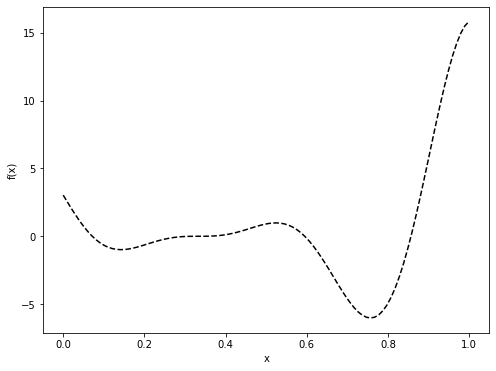

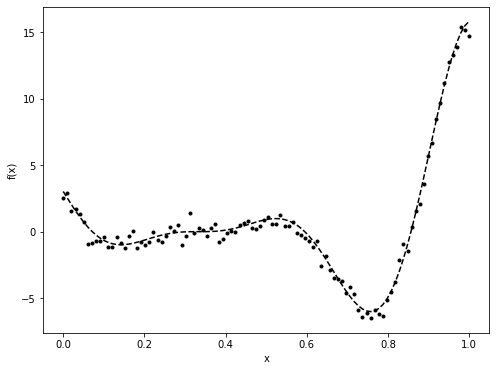

In [103]:
# the function we're going to use, the ferrester function is already implemented
#in the emukit library, as it is a really important benchmark function
from emukit.test_functions import forrester_function
target_function, space = forrester_function()

# sampling space
N = 100 # picking 100 points
X_grid = np.linspace(0, 1, N)[:,None]
Y_grid = target_function(X_grid)
Y_grid.shape

# Show function
FIGSIZE = (8, 6)
plt.figure(figsize=FIGSIZE)
plt.plot(X_grid, Y_grid,'k--')
plt.xlabel('x')
plt.ylabel('f(x)')
# Show function with noise
plt.figure(figsize=FIGSIZE)
plt.plot(X_grid, Y_grid,'k--')
plt.plot(X_grid, Y_grid + np.random.normal(0., 0.5, X_grid.shape) ,'k.')
plt.xlabel('x')
plt.ylabel('f(x)')

In [133]:
#sampling 5 data points to perform regression at
# we sample the function and look at GP prediction
# Sample from the function
# Number of samples 
num_measurements = 10

# Random sample locations
X_samples = np.random.uniform(0, 1., (num_measurements, 1))

# Get the function value with noise
Y_samples = target_function(X_samples) + np.random.normal(0., .1, (X_samples.shape[0],1))

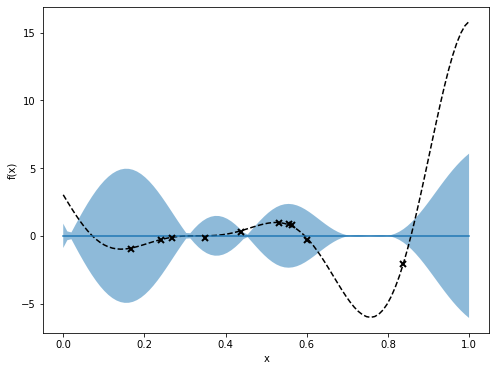

In [138]:
# Set up the kernel and the GP model
k = GPy.kern.RBF(1,lengthscale=1, variance=1)
m = GPy.models.GPRegression(X_samples, Y_samples, k)

# optimize hyperparameters
m.optimize('bfgs', max_iters=100)
    
# Identify the mean and covariance of the GP fit over the grid
mean, Cov = m.predict(X_grid, full_cov=True)

# Plot the generating curve and the GP
plt.figure(figsize = (8,6))
plt.plot(X_grid, Y_grid,'k--')
plot_gp(X_grid, mean, Cov, training_points=(X_samples,Y_samples))
m

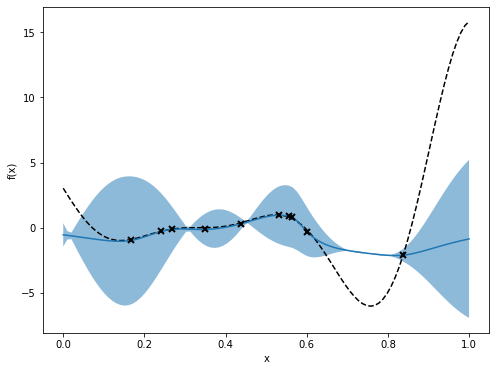

In [139]:
# Set up the kernel and the GP model
k = GPy.kern.Matern32(1)
m = GPy.models.GPRegression(X_samples, Y_samples, k)

# optimize hyperparameters
m.optimize('bfgs', max_iters=100)
    
# Identify the mean and covariance of the GP fit over the grid
mean, Cov = m.predict(X_grid, full_cov=True)

# Plot the generating curve and the GP
plt.figure(figsize = (8,6))
plt.plot(X_grid, Y_grid,'k--')
plot_gp(X_grid, mean, Cov, training_points=(X_samples,Y_samples))
m

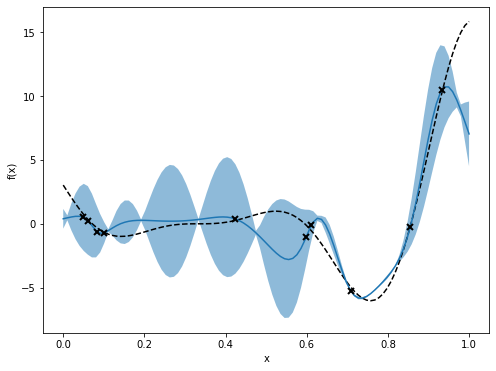

In [113]:
# Set up the kernel and the GP model
k = GPy.kern.Matern52(1)
m = GPy.models.GPRegression(X_samples, Y_samples, k)

# optimize hyperparameters
m.optimize('bfgs', max_iters=100)
    
# Identify the mean and covariance of the GP fit over the grid
mean, Cov = m.predict(X_grid, full_cov=True)

# Plot the generating curve and the GP
plt.figure(figsize = (8,6))
plt.plot(X_grid, Y_grid,'k--')
plot_gp(X_grid, mean, Cov, training_points=(X_samples,Y_samples))
m

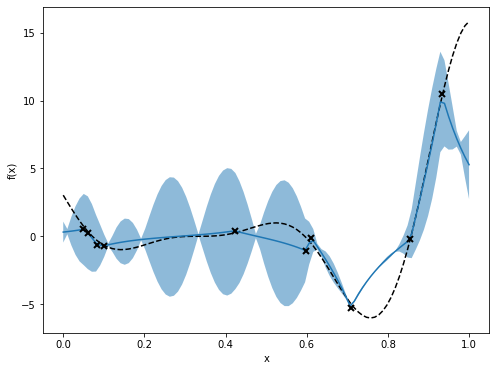

In [114]:
# Set up the kernel and the GP model
k = GPy.kern.Exponential(1)
m = GPy.models.GPRegression(X_samples, Y_samples, k)

# optimize hyperparameters
m.optimize('bfgs', max_iters=100)
    
# Identify the mean and covariance of the GP fit over the grid
mean, Cov = m.predict(X_grid, full_cov=True)

# Plot the generating curve and the GP
plt.figure(figsize = (8,6))
plt.plot(X_grid, Y_grid,'k--')
plot_gp(X_grid, mean, Cov, training_points=(X_samples,Y_samples))
m

### Active Learning & Bayesian Optimization

To perform Active Learning & Bayesian Optimization we need two ingredients:
- $f(x)$ a model to represent data as it comes in, this model usually is a GP
- $\alpha(x)$ an aquisition function to quantify desirablity of performing each   experiment.

In [115]:
from emukit.core.loop.user_function import UserFunctionWrapper
from emukit.core import ContinuousParameter, ParameterSpace
from emukit.model_wrappers.gpy_model_wrappers import GPyModelWrapper
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement, NegativeLowerConfidenceBound 
from emukit.experimental_design.acquisitions import ModelVariance
from emukit.core.optimization import GradientAcquisitionOptimizer
from emukit.core.loop.loop_state import create_loop_state
from emukit.bayesian_optimization.loops import BayesianOptimizationLoop

In [116]:
def plot_acq(X_grid, acq, x_new):
    plt.figure(figsize=(8, 3))
    plt.plot(X_grid, acq,"green") # (acq - np.min(acq)) / (np.max(acq) - np.min(acq)), "green")
    plt.axvline(x_new, color="red", linestyle="--")
    plt.xlabel("x")
    plt.ylabel("Acq.")
    plt.show()

#### Approach 1: Explore the Design space
1. Fit the GP to existing datapoints
2. Identify the point with the maximum variance
3. Access the given point
4. Repeat

##### Case 1

Iteration: 1


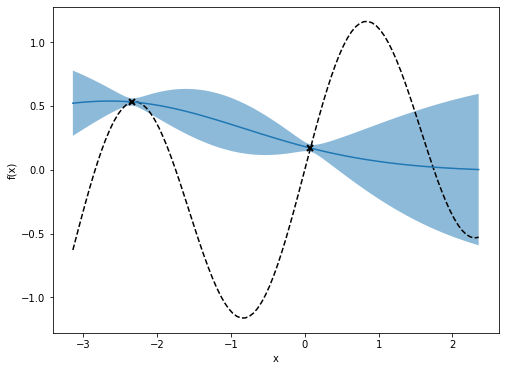

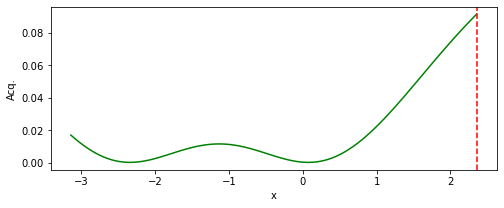

Iteration: 2


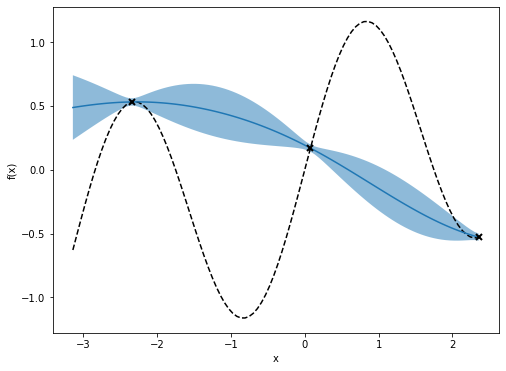

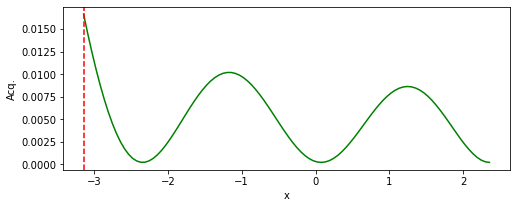

Iteration: 3


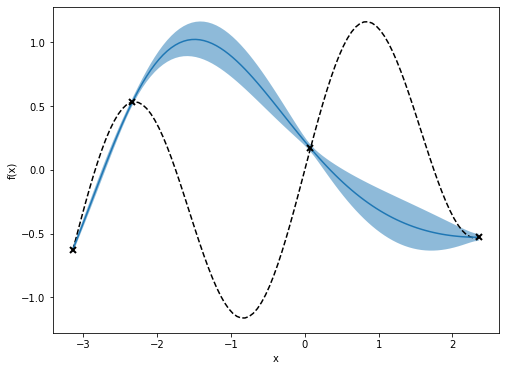

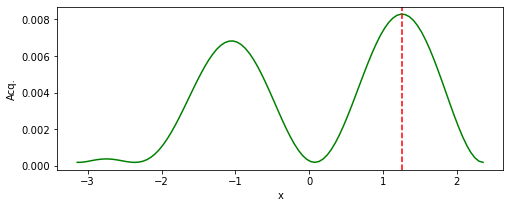

Iteration: 4


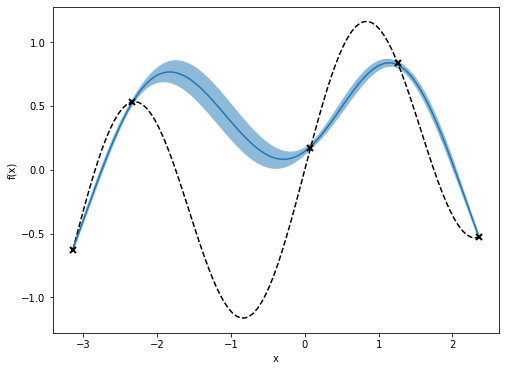

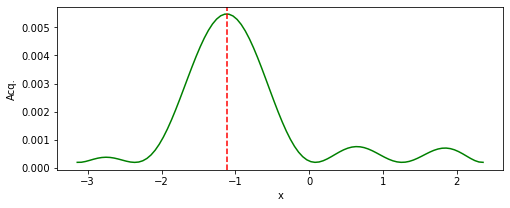

Iteration: 5


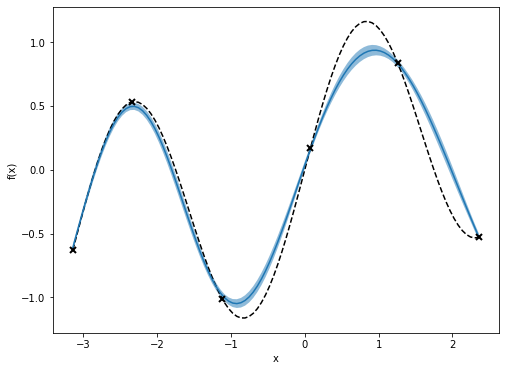

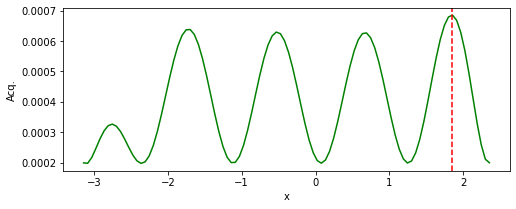

Iteration: 6


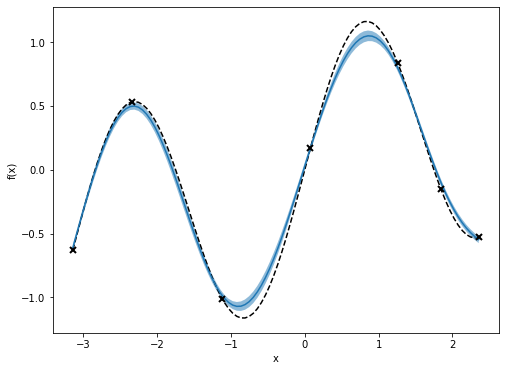

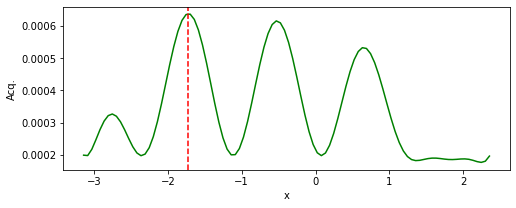

Iteration: 7


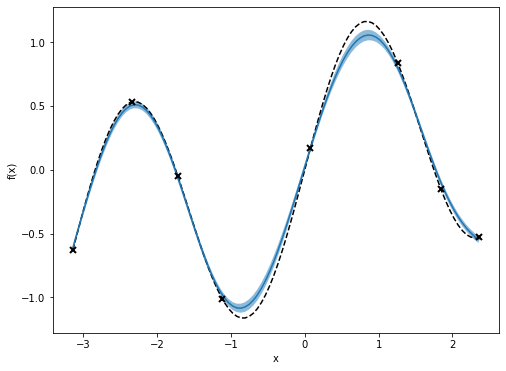

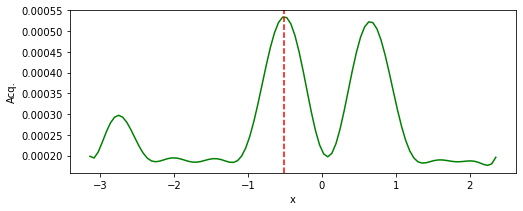

Iteration: 8


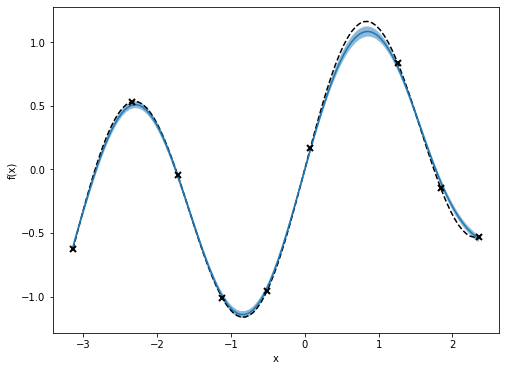

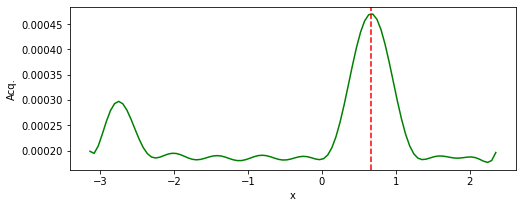

Iteration: 9


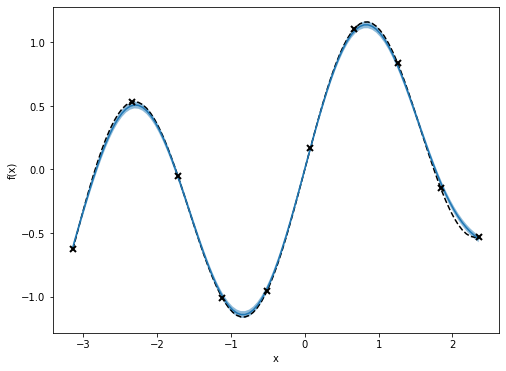

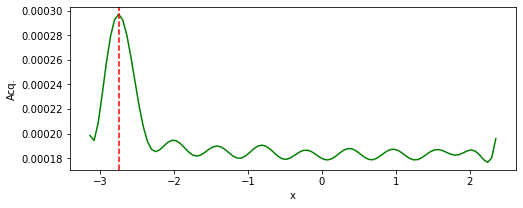

Iteration: 10


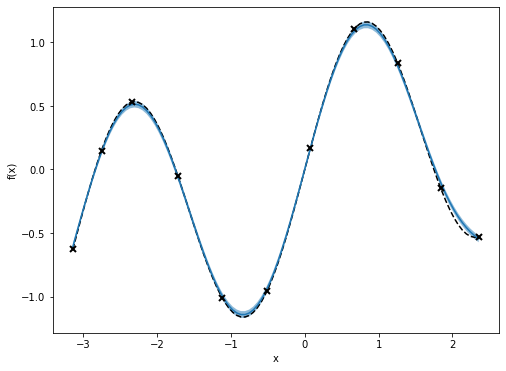

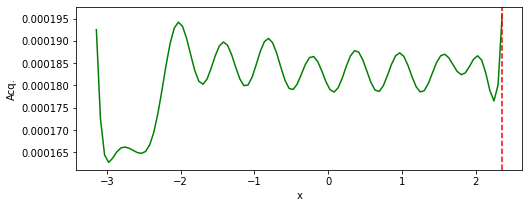

In [118]:
## the function we're going to use
f = lambda xi: np.sin(xi * 2) + .2*xi

# sampling space
N = 100 # picking 100 points
X_grid = np.linspace(-np.pi, np.pi*3/4, N)[:,None]
Y_grid = f(X_grid)
Y_grid.shape

# initial set of data
# Number of samples 
num_measurements = 2
x_min=-np.pi
x_max= np.pi * 3/4
# Random sample locations
X_init = np.random.uniform(x_min, x_max, (num_measurements, 1))

# Get the function value with noise
Y_init = f(X_init) + np.random.normal(0., .001, (X_init.shape[0],1))
i = 1
print('Iteration: ' + str(i))
#initial fit
gpy_model = GPy.models.GPRegression(X_init, Y_init, GPy.kern.Matern52(1, lengthscale=1., variance=1.), noise_var=1e-4)
emukit_model = GPyModelWrapper(gpy_model)
emukit_model.optimize()
space = ParameterSpace([ContinuousParameter('x', x_min, x_max)])
mean, var = emukit_model.predict(X_grid)

# Plot the generating curve and the GP
plt.figure(figsize = (8,6))
plt.plot(X_grid, Y_grid,'k--')
plot_gp(X_grid, mean, var, training_points=(X_init,Y_init))

acq_function = ModelVariance(emukit_model)
acq = acq_function.evaluate(X_grid)
optimizer = GradientAcquisitionOptimizer(space)
x_new, _ = optimizer.optimize(acq_function)
plot_acq(X_grid, acq, x_new)
y_new = f(x_new) + np.random.normal(0., .001)
X_init = np.append(X_init, x_new, axis=0)
Y_init = np.append(Y_init, y_new, axis=0)
emukit_model.set_data(X_init, Y_init)
for j in range(1,10):
    i+=1
    print('Iteration: ' + str(i))
    #initial fit
    
    mean, var = emukit_model.predict(X_grid)

    # Plot the generating curve and the GP
    plt.figure(figsize = (8,6))
    plt.plot(X_grid, Y_grid,'k--')
    plot_gp(X_grid, mean, var, training_points=(X_init,Y_init))

    acq = acq_function.evaluate(X_grid)
    x_new, _ = optimizer.optimize(acq_function)
    plot_acq(X_grid, acq, x_new)
    y_new = f(x_new) + np.random.normal(0., .001)
    X_init = np.append(X_init, x_new, axis=0)
    Y_init = np.append(Y_init, y_new, axis=0)
    emukit_model.set_data(X_init, Y_init)
    

##### Case 2

Iteration: 1


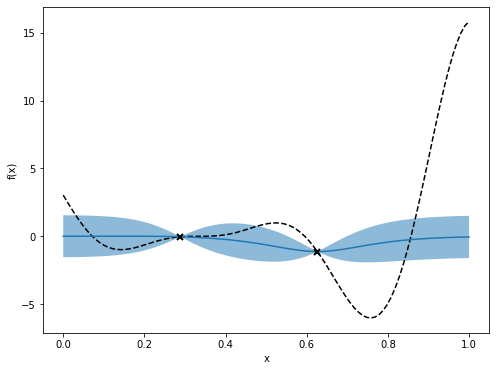

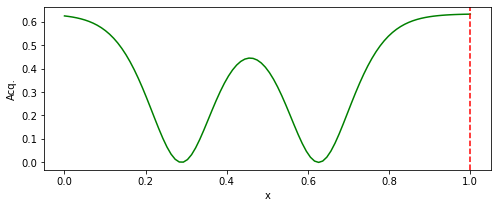

Iteration: 2


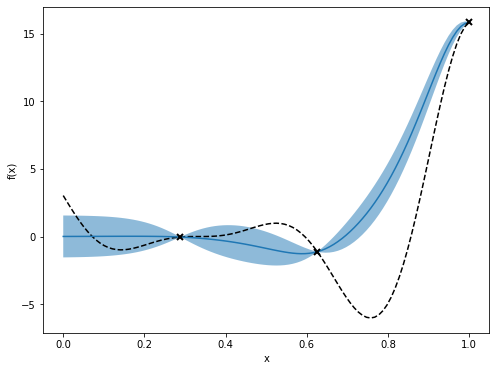

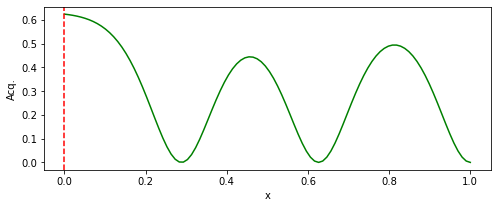

Iteration: 3


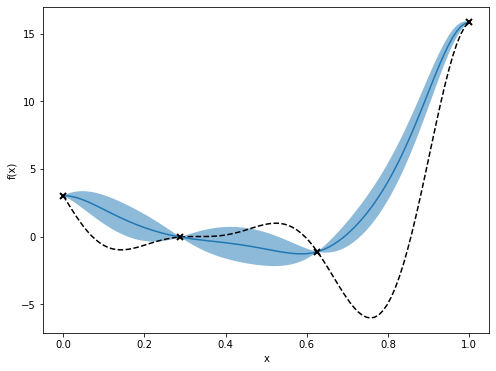

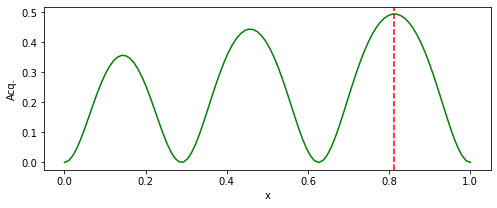

Iteration: 4


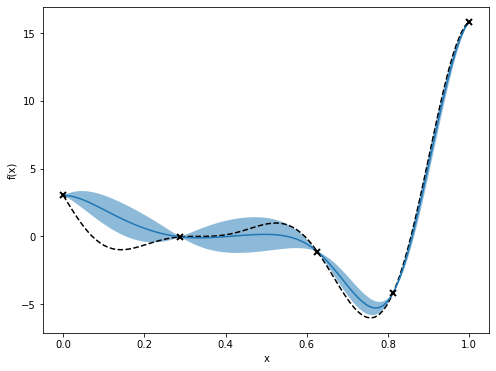

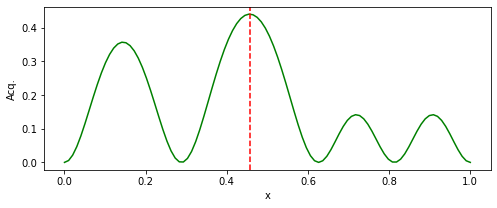

Iteration: 5


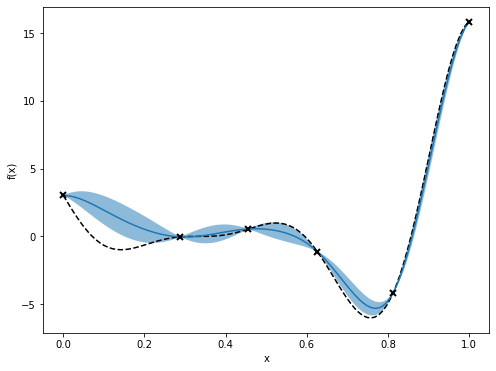

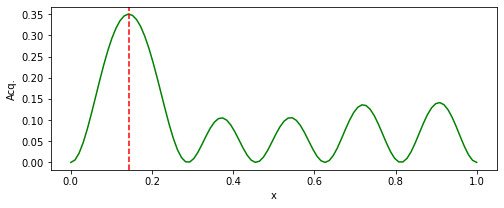

Iteration: 6


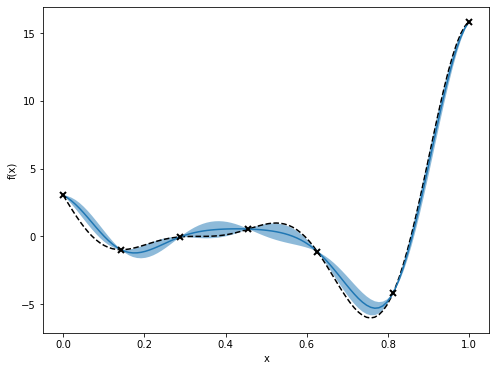

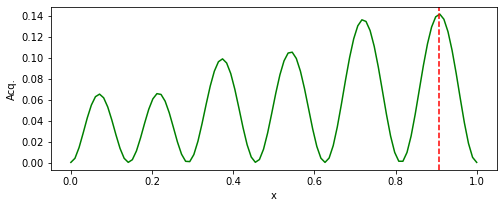

Iteration: 7


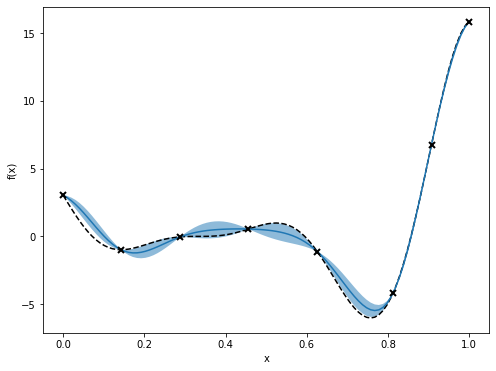

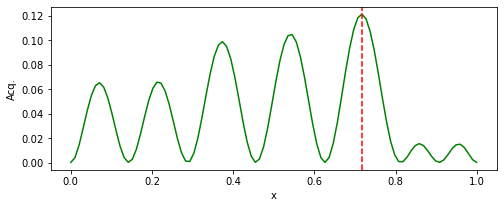

Iteration: 8


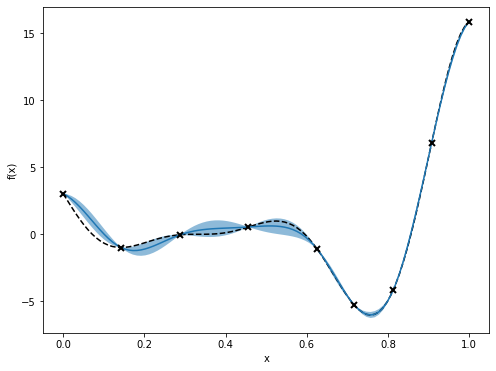

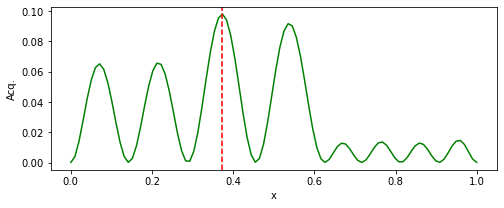

Iteration: 9


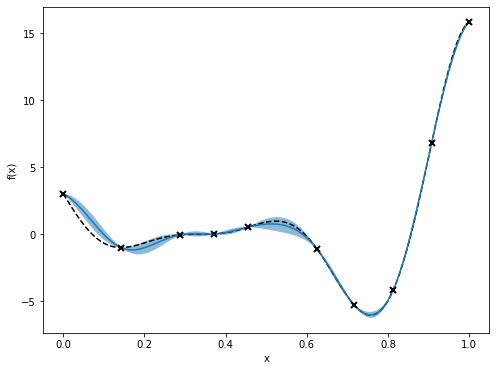

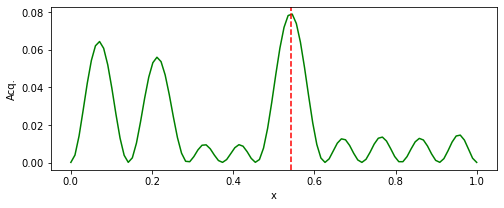

Iteration: 10


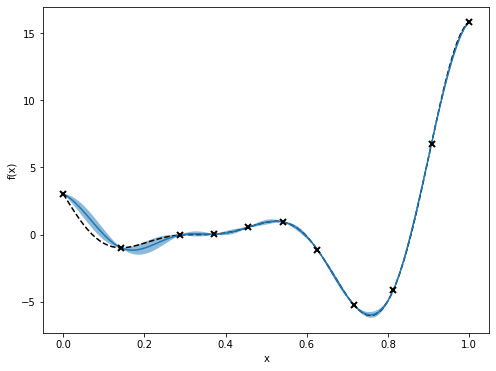

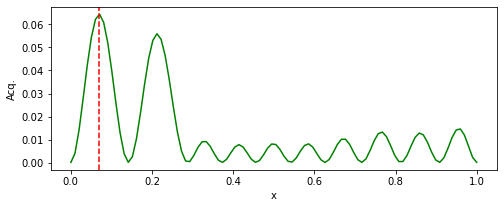

In [119]:
# the function we're going to use, the ferrester function is already implemented
#in the emukit library, as it is a really important benchmark function
from emukit.test_functions import forrester_function
f, space = forrester_function()

# sampling space
N = 100 # picking 100 points
X_grid = np.linspace(0., 1., N)[:,None]
Y_grid = f(X_grid)
Y_grid.shape

# initial set of data
# Number of samples 
num_measurements = 2
x_min=0.
x_max= 1.
# Random sample locations
X_init = np.random.uniform(x_min, x_max, (num_measurements, 1))

# Get the function value with noise
Y_init = f(X_init) + np.random.normal(0., .001, (X_init.shape[0],1))
i = 1
print('Iteration: ' + str(i))
#initial fit
gpy_model = GPy.models.GPRegression(X_init, Y_init, GPy.kern.Matern52(1, lengthscale=1., variance=1.), noise_var=1e-4)
emukit_model = GPyModelWrapper(gpy_model)
emukit_model.optimize()
space = ParameterSpace([ContinuousParameter('x', x_min, x_max)])
mean, var = emukit_model.predict(X_grid)

# Plot the generating curve and the GP
plt.figure(figsize = (8,6))
plt.plot(X_grid, Y_grid,'k--')
plot_gp(X_grid, mean, var, training_points=(X_init,Y_init))

acq_function = ModelVariance(emukit_model)
acq = acq_function.evaluate(X_grid)
optimizer = GradientAcquisitionOptimizer(space)
x_new, _ = optimizer.optimize(acq_function)
plot_acq(X_grid, acq, x_new)
y_new = f(x_new) + np.random.normal(0., .001)
X_init = np.append(X_init, x_new, axis=0)
Y_init = np.append(Y_init, y_new, axis=0)
emukit_model.set_data(X_init, Y_init)
for j in range(1,10):
    i+=1
    print('Iteration: ' + str(i))
    #initial fit
    
    mean, var = emukit_model.predict(X_grid)

    # Plot the generating curve and the GP
    plt.figure(figsize = (8,6))
    plt.plot(X_grid, Y_grid,'k--')
    plot_gp(X_grid, mean, var, training_points=(X_init,Y_init))

    acq = acq_function.evaluate(X_grid)
    x_new, _ = optimizer.optimize(acq_function)
    plot_acq(X_grid, acq, x_new)
    y_new = f(x_new) + np.random.normal(0., .001)
    X_init = np.append(X_init, x_new, axis=0)
    Y_init = np.append(Y_init, y_new, axis=0)
    emukit_model.set_data(X_init, Y_init)
    

#### Approach 2: Exploit Prior Knowledge
1. Fit the GP to existing datapoints
2. Identify the point with the minimum mean value
3. Access the given point
4. Repeat

##### Case 1

Iteration: 1


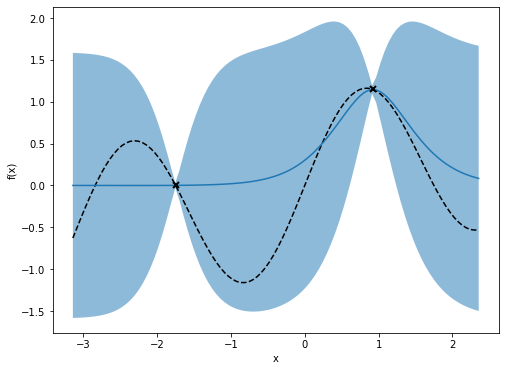

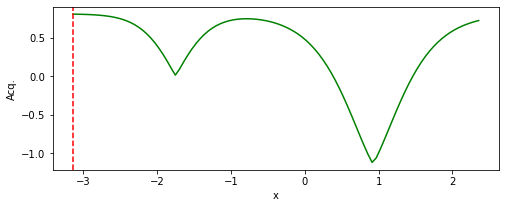

Iteration: 2


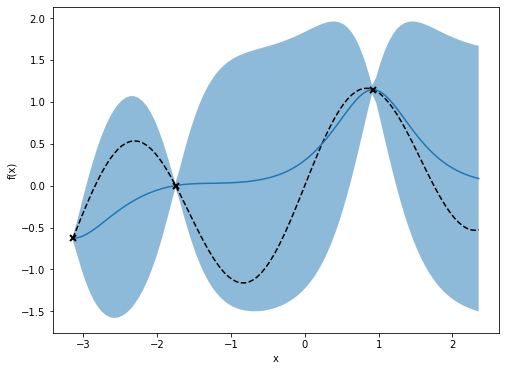

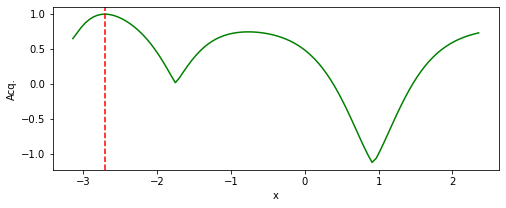

Iteration: 3


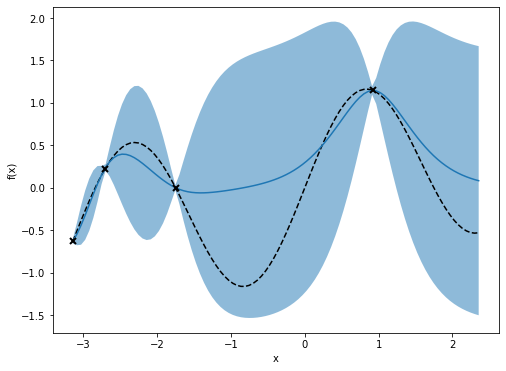

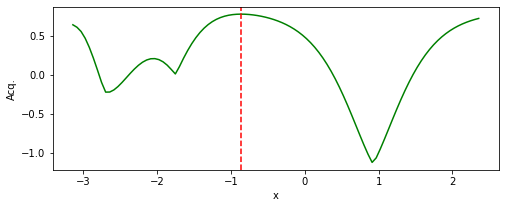

Iteration: 4


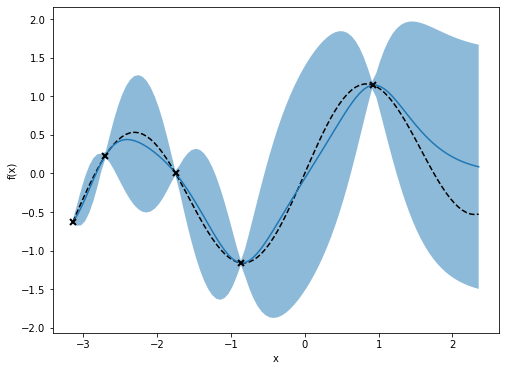

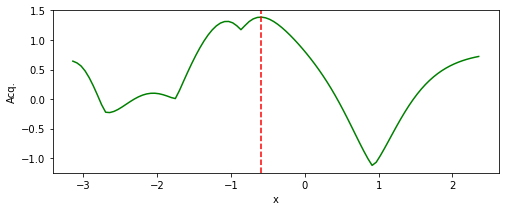

Iteration: 5


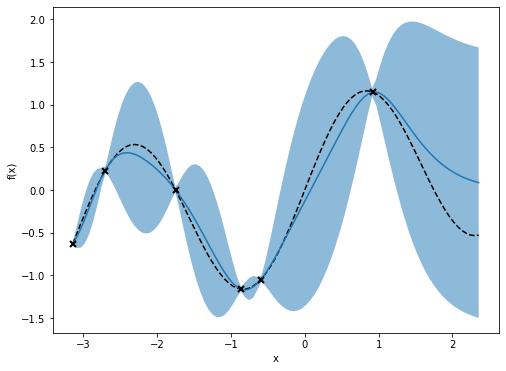

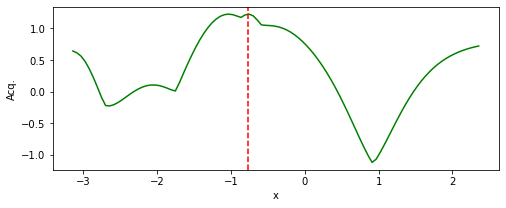

Iteration: 6


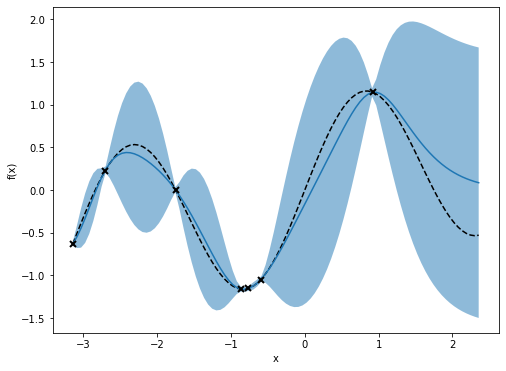

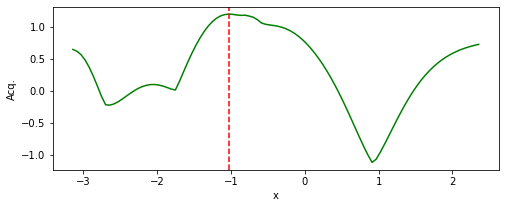

Iteration: 7


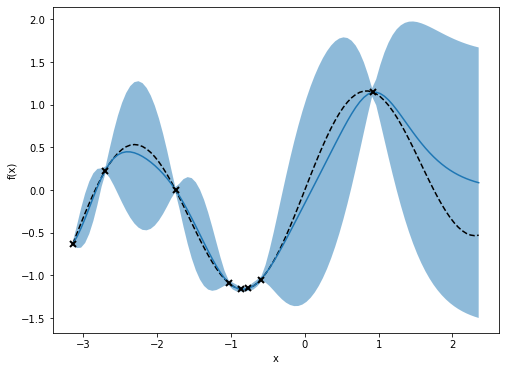

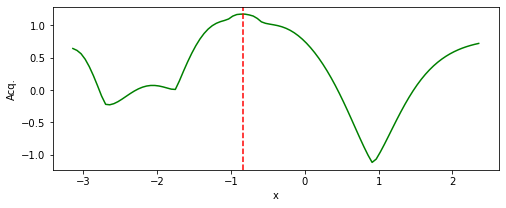

Iteration: 8


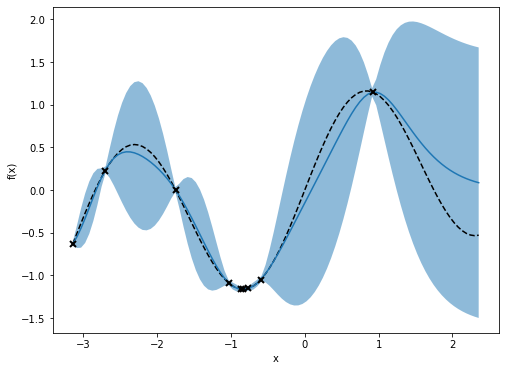

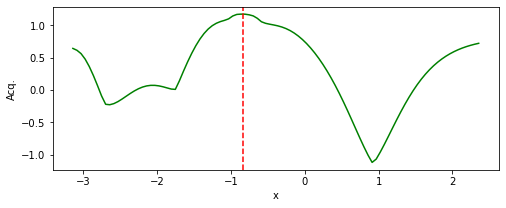

Iteration: 9


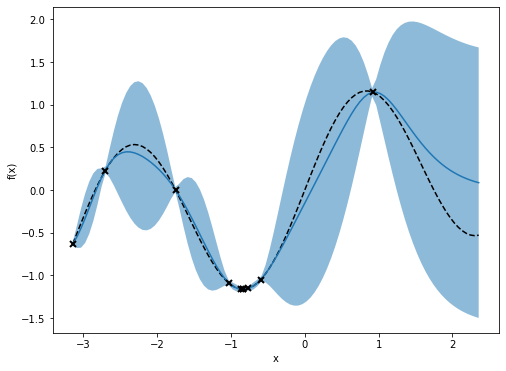

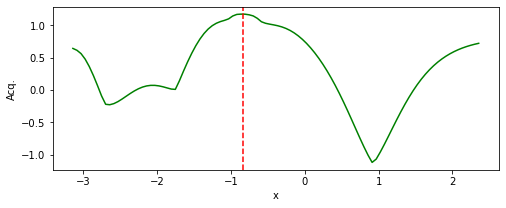

Iteration: 10


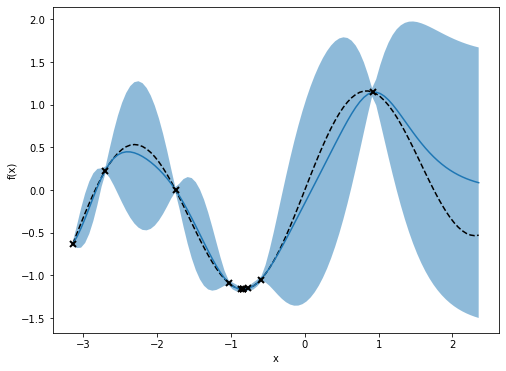

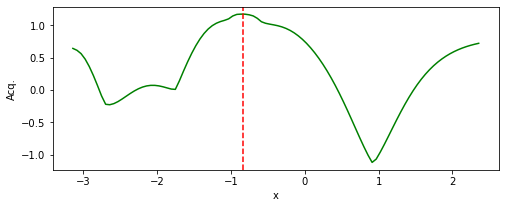

In [120]:
## the function we're going to use
f = lambda xi: np.sin(xi * 2) + .2*xi

# sampling space
N = 100 # picking 100 points
X_grid = np.linspace(-np.pi, np.pi*3/4, N)[:,None]
Y_grid = f(X_grid)
Y_grid.shape

# initial set of data
# Number of samples 
num_measurements = 2
x_min=-np.pi
x_max= np.pi * 3/4
# Random sample locations
X_init = np.random.uniform(x_min, x_max, (num_measurements, 1))

# Get the function value with noise
Y_init = f(X_init) + np.random.normal(0., .001, (X_init.shape[0],1))
i = 0
#print('Iteration: ' + str(i))
#initial fit
gpy_model = GPy.models.GPRegression(X_init, Y_init, GPy.kern.Matern52(1, lengthscale=1., variance=1.), noise_var=1e-4)
emukit_model = GPyModelWrapper(gpy_model)
emukit_model.optimize()
space = ParameterSpace([ContinuousParameter('x', x_min, x_max)])

acq_function = NegativeLowerConfidenceBound(emukit_model)
acq = acq_function.evaluate(X_grid)
optimizer = GradientAcquisitionOptimizer(space)
initial_loop_state = create_loop_state(X_init, Y_init)
bo_loop = BayesianOptimizationLoop(
        model=emukit_model,
        space=space,
        acquisition=acq_function,
        acquisition_optimizer=optimizer,
        update_interval=1,
        batch_size=1)
for j in range(1,11):
    i+=1
    print('Iteration: ' + str(i))
    #initial fit
    
    mean, var = emukit_model.predict(X_grid)

    # Plot the generating curve and the GP
    plt.figure(figsize = (8,6))
    plt.plot(X_grid, Y_grid,'k--')
    plot_gp(X_grid, mean, var, training_points=(X_init,Y_init))

    acq = acq_function.evaluate(X_grid)
    x_new, _ = optimizer.optimize(acq_function)
    plot_acq(X_grid, acq, x_new)
    y_new = f(x_new) + np.random.normal(0., .001)
    X_init = np.append(X_init, x_new, axis=0)
    Y_init = np.append(Y_init, y_new, axis=0)
    emukit_model.set_data(X_init, Y_init)


##### Case 2

Iteration: 1


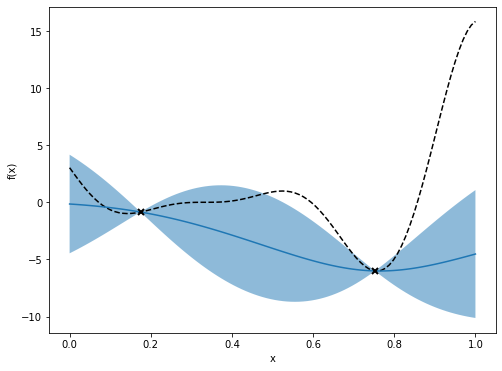

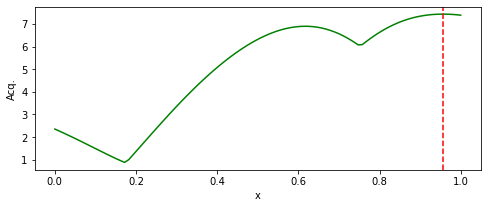

Iteration: 2


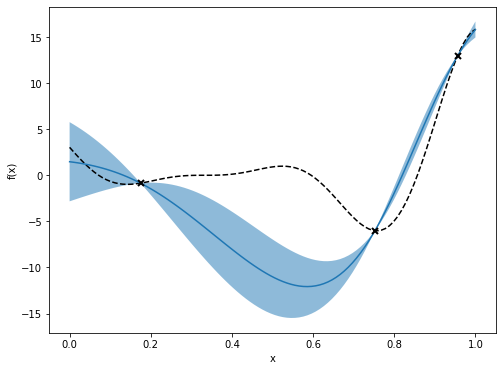

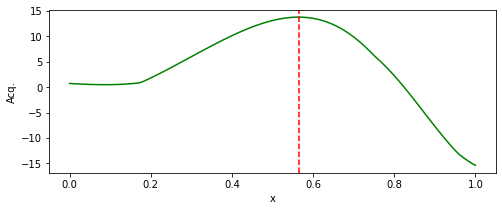

Iteration: 3


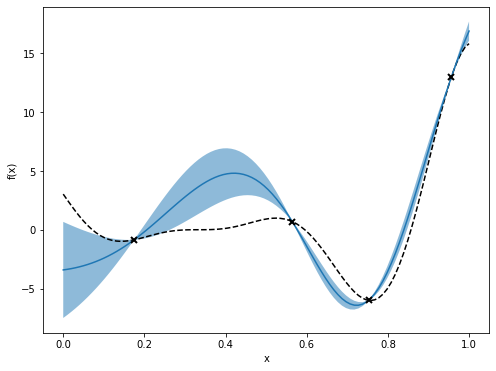

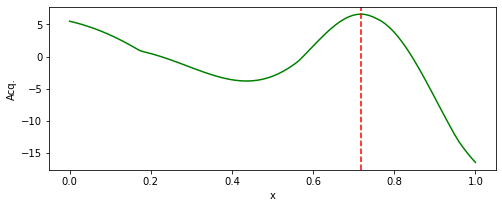

Iteration: 4


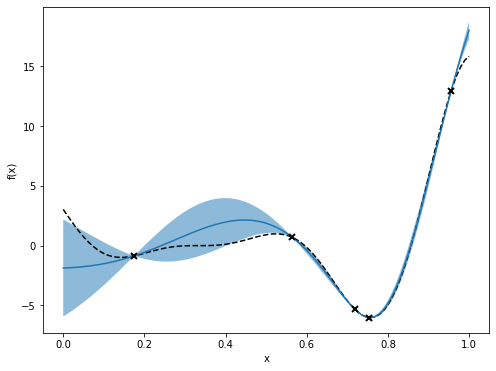

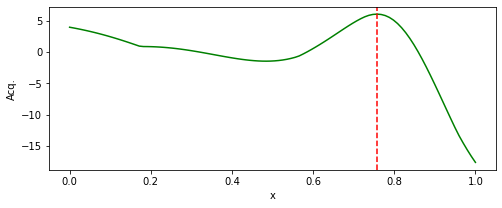

Iteration: 5


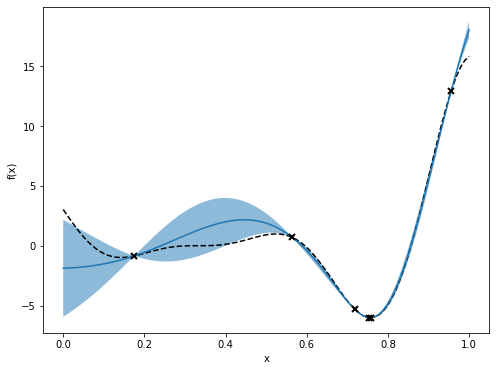

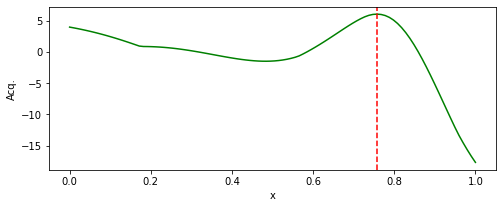

Iteration: 6


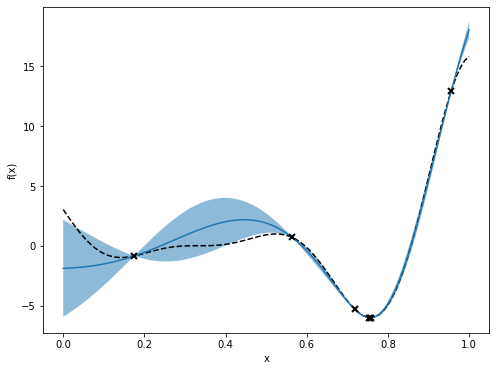

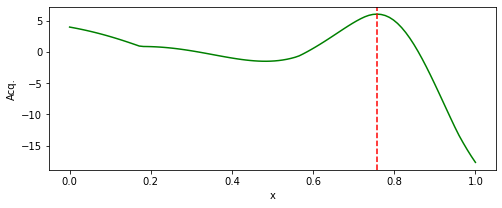

Iteration: 7


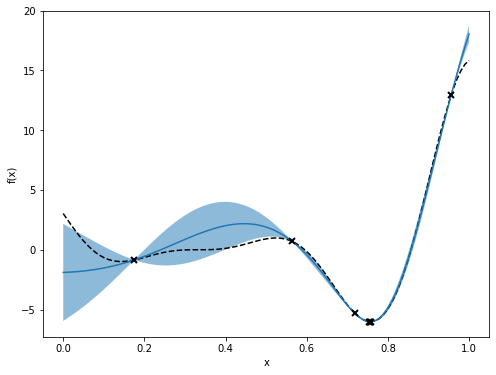

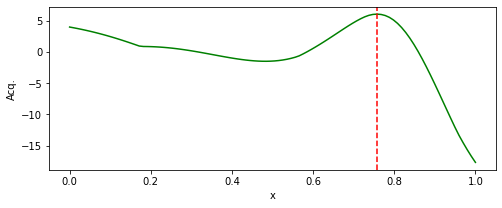

Iteration: 8


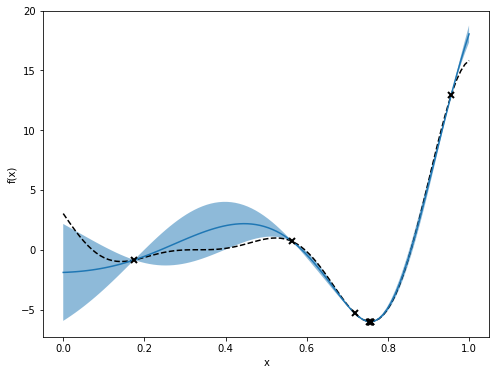

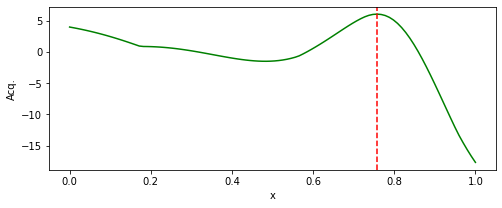

Iteration: 9


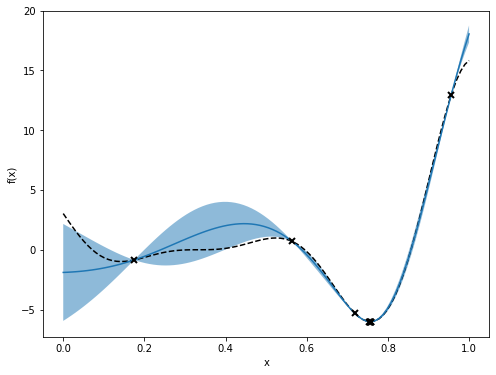

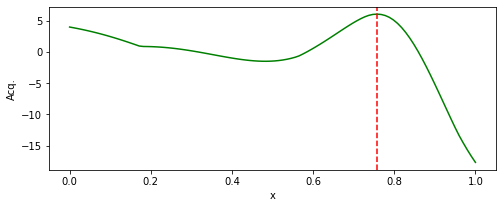

Iteration: 10


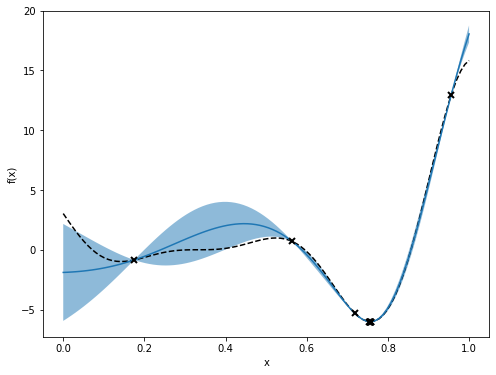

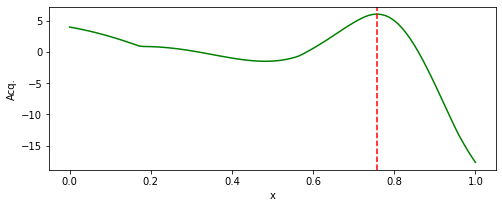

In [122]:
# the function we're going to use, the ferrester function is already implemented
#in the emukit library, as it is a really important benchmark function
from emukit.test_functions import forrester_function
f, space = forrester_function()

# sampling space
N = 100 # picking 100 points
X_grid = np.linspace(0., 1., N)[:,None]
Y_grid = f(X_grid)
Y_grid.shape

# initial set of data
# Number of samples 
num_measurements = 2
x_min= 0
x_max= 1
# Random sample locations
X_init = np.random.uniform(x_min, x_max, (num_measurements, 1))

# Get the function value with noise
Y_init = f(X_init) + np.random.normal(0., .001, (X_init.shape[0],1))
i = 0
#print('Iteration: ' + str(i))
#initial fit
gpy_model = GPy.models.GPRegression(X_init, Y_init, GPy.kern.Matern52(1, lengthscale=1., variance=1.), noise_var=1e-4)
emukit_model = GPyModelWrapper(gpy_model)
emukit_model.optimize()
space = ParameterSpace([ContinuousParameter('x', x_min, x_max)])

acq_function = NegativeLowerConfidenceBound(emukit_model)
acq = acq_function.evaluate(X_grid)
optimizer = GradientAcquisitionOptimizer(space)
initial_loop_state = create_loop_state(X_init, Y_init)
bo_loop = BayesianOptimizationLoop(
        model=emukit_model,
        space=space,
        acquisition=acq_function,
        acquisition_optimizer=optimizer,
        update_interval=1,
        batch_size=1)
for j in range(1,11):
    i+=1
    print('Iteration: ' + str(i))
    #initial fit
    
    mean, var = emukit_model.predict(X_grid)

    # Plot the generating curve and the GP
    plt.figure(figsize = (8,6))
    plt.plot(X_grid, Y_grid,'k--')
    plot_gp(X_grid, mean, var, training_points=(X_init,Y_init))

    acq = acq_function.evaluate(X_grid)
    x_new, _ = optimizer.optimize(acq_function)
    plot_acq(X_grid, acq, x_new)
    y_new = f(x_new) + np.random.normal(0., .001)
    X_init = np.append(X_init, x_new, axis=0)
    Y_init = np.append(Y_init, y_new, axis=0)
    emukit_model.set_data(X_init, Y_init)


#### Approach 3: Exploit prior Knowledge & Explore the Design space
1. Fit the GP to existing datapoints
2. Identify the point most promising to be a maximum taking into account
   its mean value and variance
3. Access the given point
4. Repeat

##### Case 1

Iteration: 1


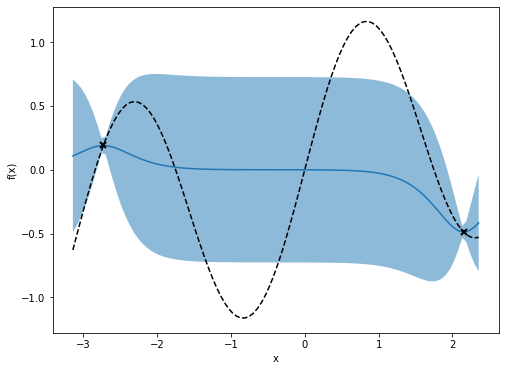

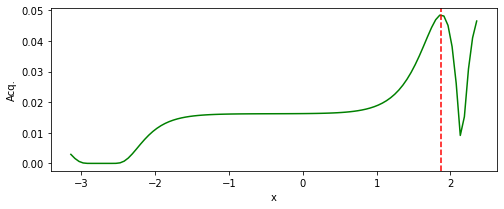

Iteration: 2


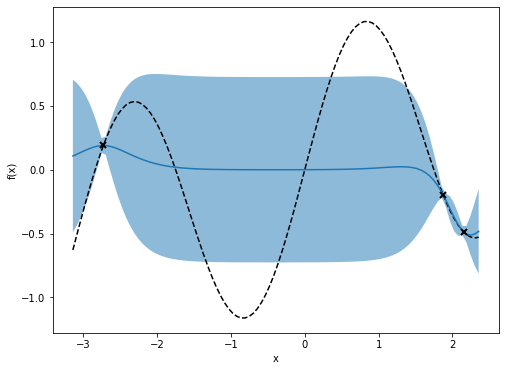

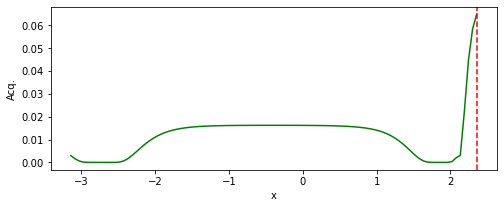

Iteration: 3


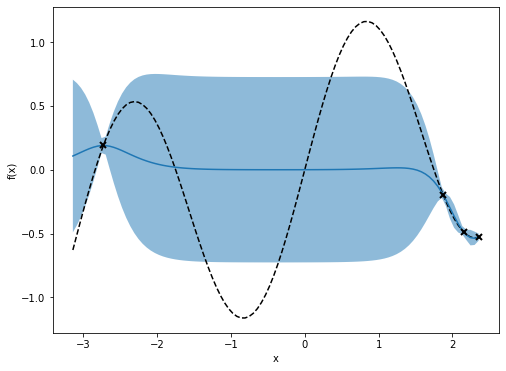

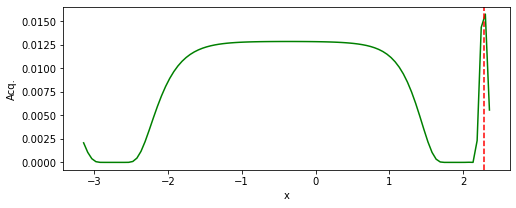

Iteration: 4


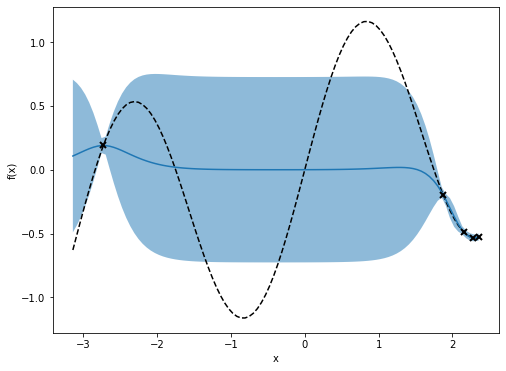

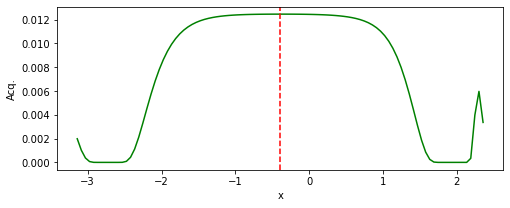

Iteration: 5


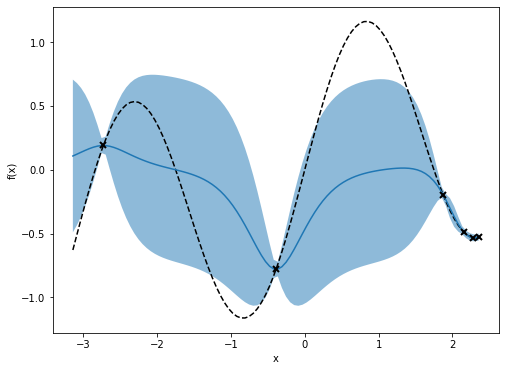

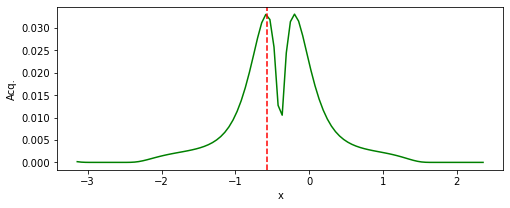

Iteration: 6


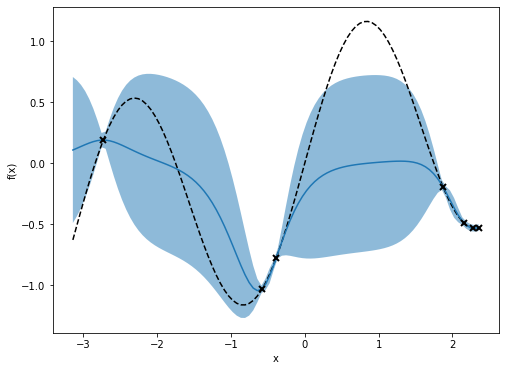

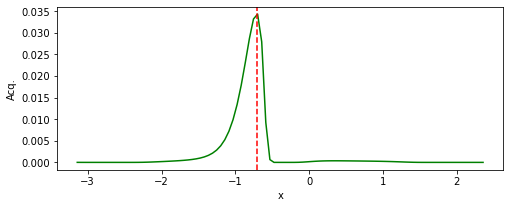

Iteration: 7


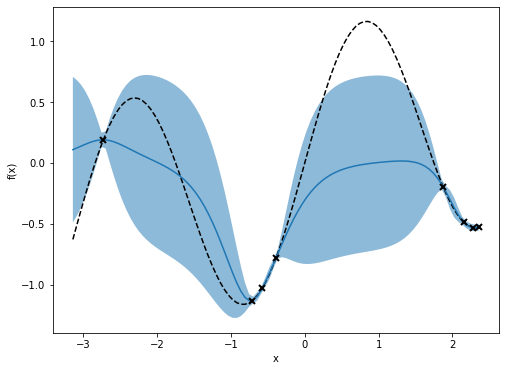

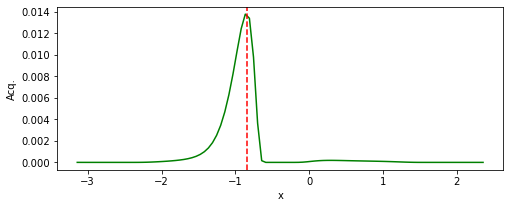

Iteration: 8


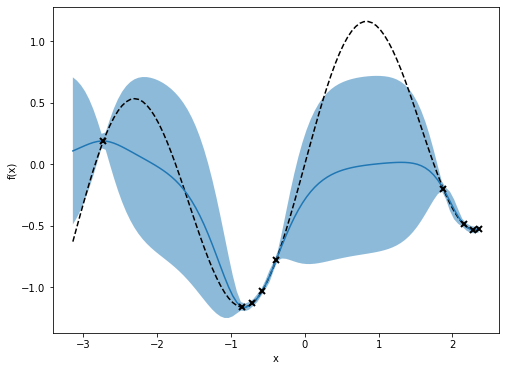

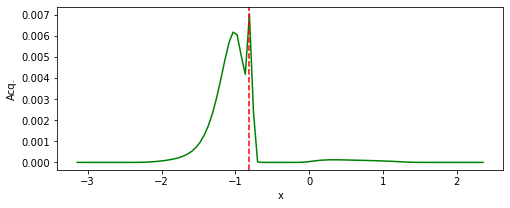

Iteration: 9


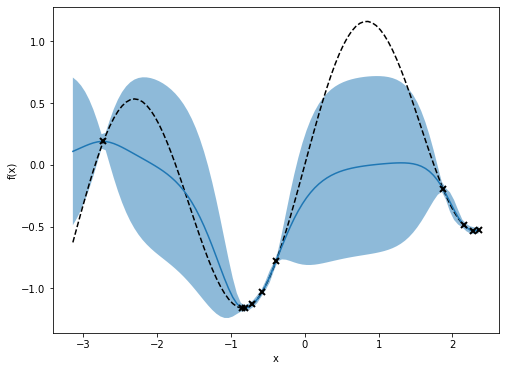

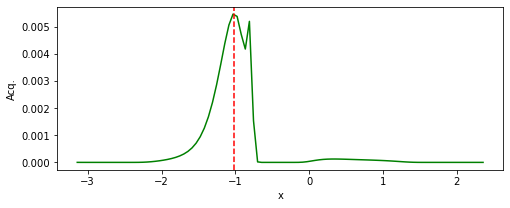

Iteration: 10


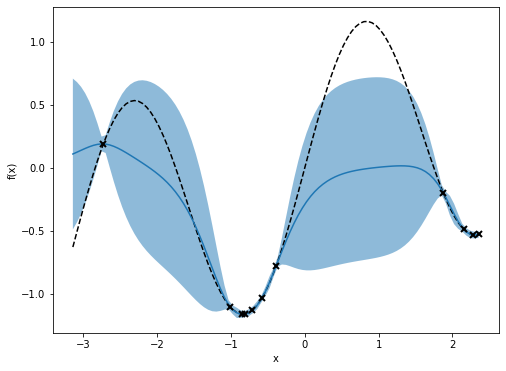

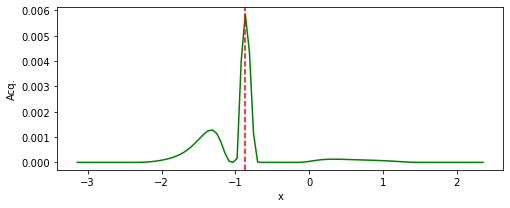

In [124]:
## the function we're going to use
f = lambda xi: np.sin(xi * 2) + .2*xi

# sampling space
N = 100 # picking 100 points
X_grid = np.linspace(-np.pi, np.pi*3/4, N)[:,None]
Y_grid = f(X_grid)
Y_grid.shape

# initial set of data
# Number of samples 
num_measurements = 2
x_min=-np.pi
x_max= np.pi * 3/4
# Random sample locations
X_init = np.random.uniform(x_min, x_max, (num_measurements, 1))

# Get the function value with noise
Y_init = f(X_init) + np.random.normal(0., .001, (X_init.shape[0],1))
i = 0
#print('Iteration: ' + str(i))
#initial fit
gpy_model = GPy.models.GPRegression(X_init, Y_init, GPy.kern.Matern52(1, lengthscale=1., variance=1.), noise_var=1e-4)
emukit_model = GPyModelWrapper(gpy_model)
emukit_model.optimize()
space = ParameterSpace([ContinuousParameter('x', x_min, x_max)])

acq_function = ExpectedImprovement(emukit_model)
acq = acq_function.evaluate(X_grid)
optimizer = GradientAcquisitionOptimizer(space)
initial_loop_state = create_loop_state(X_init, Y_init)
bo_loop = BayesianOptimizationLoop(
        model=emukit_model,
        space=space,
        acquisition=acq_function,
        acquisition_optimizer=optimizer,
        update_interval=1,
        batch_size=1)
for j in range(1,11):
    i+=1
    print('Iteration: ' + str(i))
    #initial fit
    
    mean, var = emukit_model.predict(X_grid)

    # Plot the generating curve and the GP
    plt.figure(figsize = (8,6))
    plt.plot(X_grid, Y_grid,'k--')
    plot_gp(X_grid, mean, var, training_points=(X_init,Y_init))

    acq = acq_function.evaluate(X_grid)
    x_new, _ = optimizer.optimize(acq_function)
    plot_acq(X_grid, acq, x_new)
    y_new = f(x_new) + np.random.normal(0., .001)
    X_init = np.append(X_init, x_new, axis=0)
    Y_init = np.append(Y_init, y_new, axis=0)
    emukit_model.set_data(X_init, Y_init)


##### Case 2

Iteration: 1


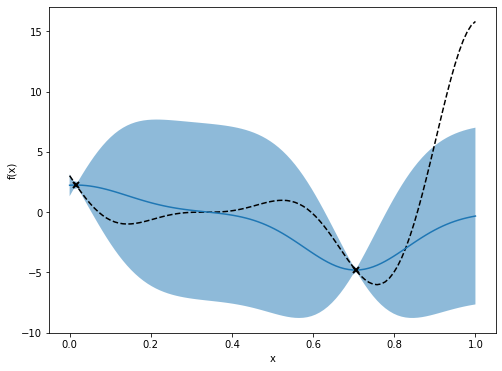

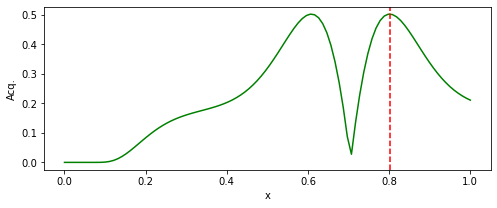

Iteration: 2


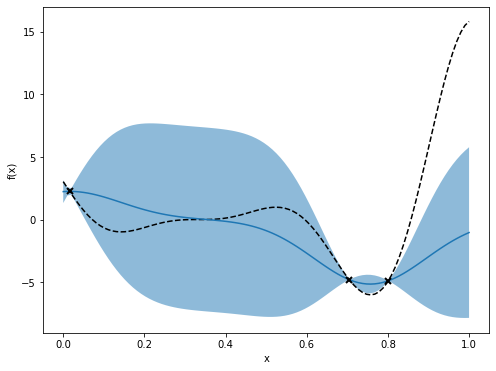

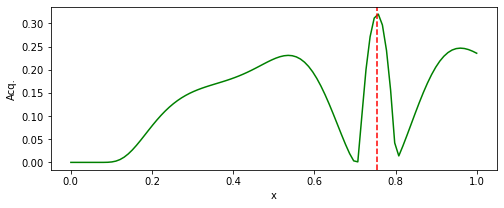

Iteration: 3


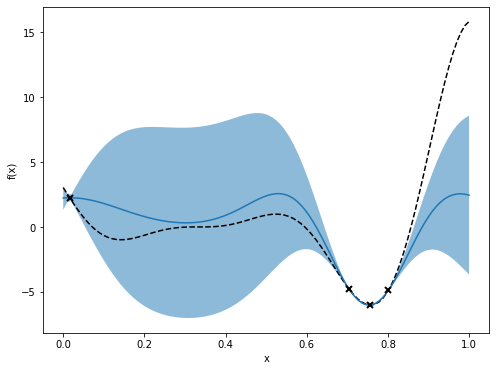

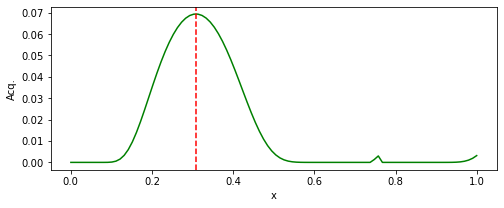

Iteration: 4


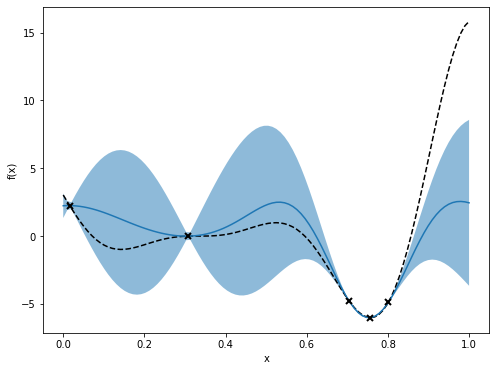

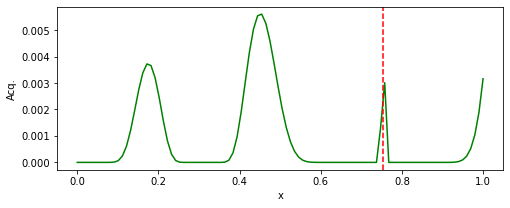

Iteration: 5


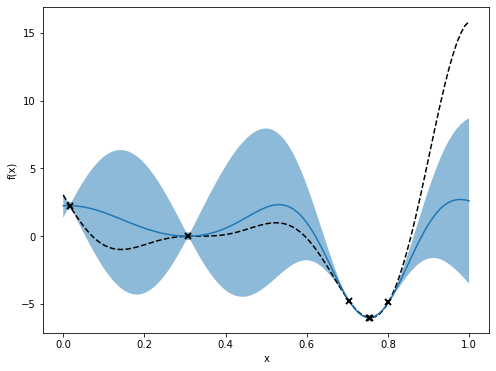

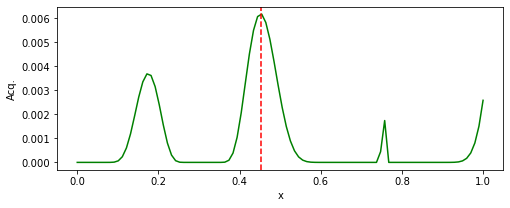

Iteration: 6


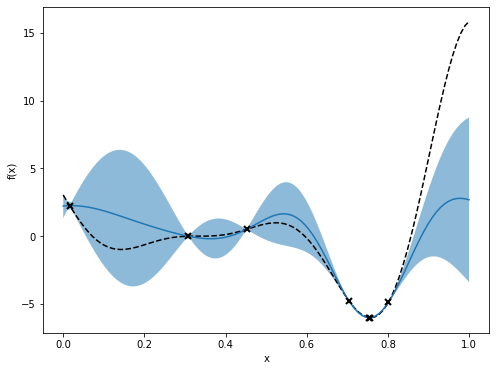

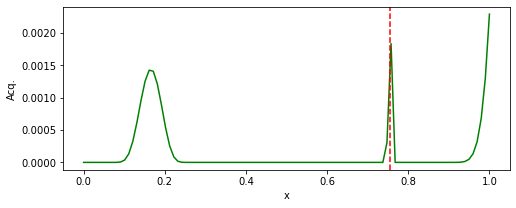

Iteration: 7


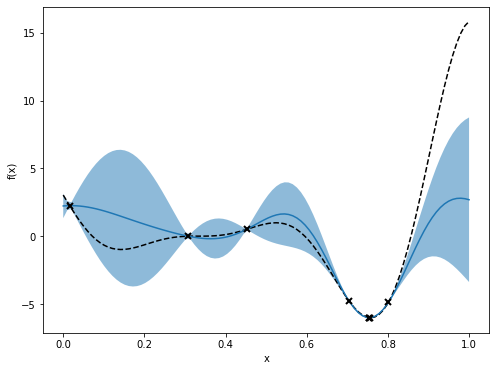

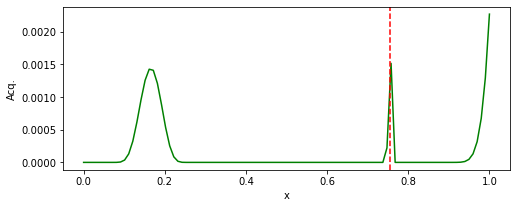

Iteration: 8


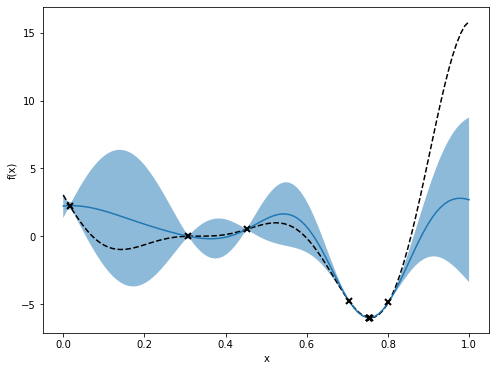

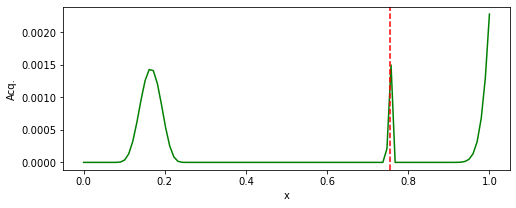

Iteration: 9


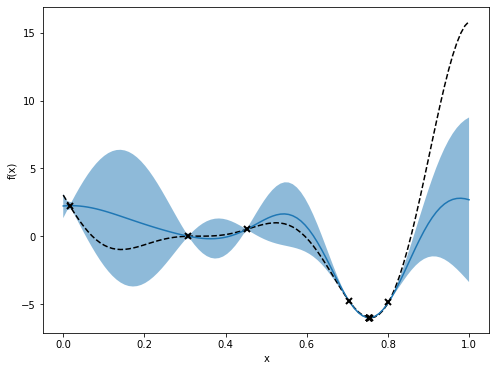

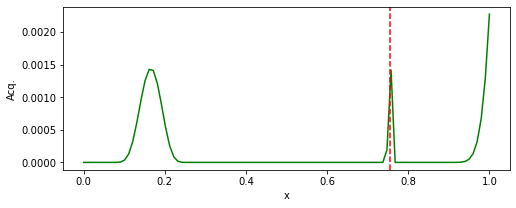

Iteration: 10


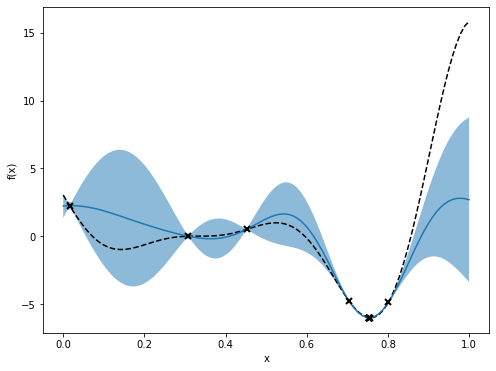

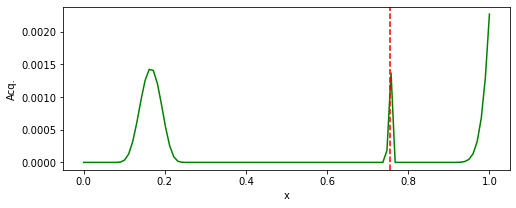

In [131]:
# the function we're going to use, the ferrester function is already implemented
#in the emukit library, as it is a really important benchmark function
from emukit.test_functions import forrester_function
f, space = forrester_function()

# sampling space
N = 100 # picking 100 points
X_grid = np.linspace(0., 1., N)[:,None]
Y_grid = target_function(X_grid)
Y_grid.shape

# initial set of data
# Number of samples 
num_measurements = 2
x_min=0.
x_max= 1.
# Random sample locations
X_init = np.random.uniform(x_min, x_max, (num_measurements, 1))

# Get the function value with noise
Y_init = f(X_init) + np.random.normal(0., .001, (X_init.shape[0],1))
i = 0
#print('Iteration: ' + str(i))
#initial fit
gpy_model = GPy.models.GPRegression(X_init, Y_init, GPy.kern.RBF(1, lengthscale=1., variance=1.), noise_var=1e-4)
emukit_model = GPyModelWrapper(gpy_model)
emukit_model.optimize()
space = ParameterSpace([ContinuousParameter('x', x_min, x_max)])

acq_function = ExpectedImprovement(emukit_model)
acq = acq_function.evaluate(X_grid)
optimizer = GradientAcquisitionOptimizer(space)
initial_loop_state = create_loop_state(X_init, Y_init)
bo_loop = BayesianOptimizationLoop(
        model=emukit_model,
        space=space,
        acquisition=acq_function,
        acquisition_optimizer=optimizer,
        update_interval=1,
        batch_size=1)
for j in range(1,11):
    i+=1
    print('Iteration: ' + str(i))
    #initial fit
    
    mean, var = emukit_model.predict(X_grid)

    # Plot the generating curve and the GP
    plt.figure(figsize = (8,6))
    plt.plot(X_grid, Y_grid,'k--')
    plot_gp(X_grid, mean, var, training_points=(X_init,Y_init))

    acq = acq_function.evaluate(X_grid)
    x_new, _ = optimizer.optimize(acq_function)
    plot_acq(X_grid, acq, x_new)
    y_new = f(x_new) + np.random.normal(0., .001)
    X_init = np.append(X_init, x_new, axis=0)
    Y_init = np.append(Y_init, y_new, axis=0)
    emukit_model.set_data(X_init, Y_init)
